In [14]:
import gym
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gym import wrappers
from datetime import datetime

In [15]:
def build_state(features):
    return int(''.join(str(int(_)) for _ in features))

In [16]:
def to_bin(value, bins):
    return np.digitize(x=[value], bins=bins)[0]

In [17]:
class FeatureTransformer:
    def __init__(self):
        self.cart_position_bins = np.linspace(-2.4, 2.4, 9)
        self.cart_velocity_bins = np.linspace(-2, 2, 9)
        self.pole_angle_bins = np.linspace(-0.4, 0.4, 9)
        self.pole_velocity_bins = np.linspace(-3.5, 3.5, 9)
    def transform(self, observation):
        cart_pos, cart_vel, pole_angle, pole_vel = observation
        return build_state([
            to_bin(cart_pos, self.cart_position_bins),
            to_bin(cart_vel, self.cart_velocity_bins),
            to_bin(pole_angle, self.pole_angle_bins),
            to_bin(pole_vel, self.pole_velocity_bins)
        ])

In [20]:
class Model:
    def __init__(self, env, feature_transformer):
        self.env = env
        self.feature_transformer = feature_transformer
        num_states = 10**env.observation_space.shape[0]
        num_actions = env.action_space.n
        self.Q = np.random.uniform(low=-1, high=1, size=(num_states, num_actions))
    
    def predict(self, s):
        x = self.feature_transformer.transform(s)
        return self.Q[x]
    
    def update(self, s, a, G):
        x = self.feature_transformer.transform(s)
        self.Q[x,a] += 1e-2*(G-self.Q[x,a])

    def sample_action(self, s, eps):
        if np.random.random()<eps:
            return self.env.action_space.sample()
        else:
            p = self.predict(s)
            return np.argmax(p)


In [27]:
def play_one(model, eps, gamma):
    observation = env.reset()
    done = False
    totalreward = 0
    iters = 0
    while not done:
        action = model.sample_action(observation, eps)
        prev_observation = observation
        observation, reward, done, info = env.step(action)
        
        totalreward += reward
        
        if done and iters<199:
            reward = -300
        
        G = reward + gamma*np.max(model.predict(observation))
        model.update(prev_observation, action, G)
        iters += 1
    return totalreward

In [28]:
def plot_running_avg(totalrewards):
    N = len(totalrewards)
    running_avg = np.empty(N)
    for t in range(N):
        running_avg[t] = totalrewards[max(0,t-100):(t+1)].mean()
        plt.plot(running_avg)
        plt.title("Running Average")
        plt.show()

episode: 0 total reward: 13.0 eps: 1.0
episode: 100 total reward: 47.0 eps: 0.099503719021
episode: 200 total reward: 77.0 eps: 0.0705345615859
episode: 300 total reward: 29.0 eps: 0.0576390417704
episode: 400 total reward: 100.0 eps: 0.0499376169439
episode: 500 total reward: 47.0 eps: 0.0446767051609
episode: 600 total reward: 96.0 eps: 0.0407908508224
episode: 700 total reward: 43.0 eps: 0.03776947873
episode: 800 total reward: 112.0 eps: 0.0353332626669
episode: 900 total reward: 145.0 eps: 0.0333148302326
episode: 1000 total reward: 188.0 eps: 0.0316069770621
episode: 1100 total reward: 102.0 eps: 0.0301374387339
episode: 1200 total reward: 156.0 eps: 0.0288554928412
episode: 1300 total reward: 147.0 eps: 0.0277243486501
episode: 1400 total reward: 132.0 eps: 0.0267165842573
episode: 1500 total reward: 111.0 eps: 0.025811286646
episode: 1600 total reward: 159.0 eps: 0.0249921911602
episode: 1700 total reward: 194.0 eps: 0.0242464322484
episode: 1800 total reward: 102.0 eps: 0.0235

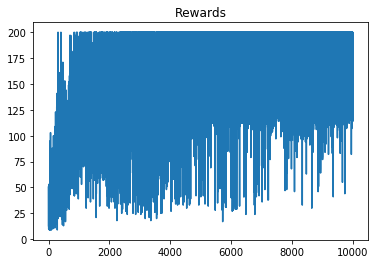

/usr/local/lib/python3.5/dist-packages/matplotlib/ticker.py:1755: RuntimeWarning: overflow encountered in multiply
  steps = self._extended_steps * scale


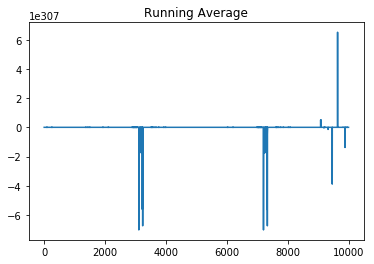

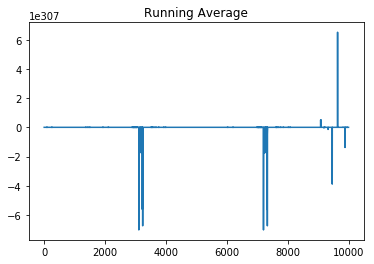

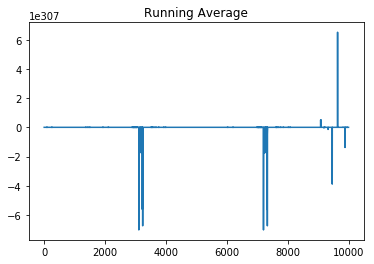

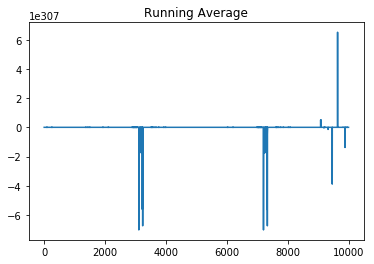

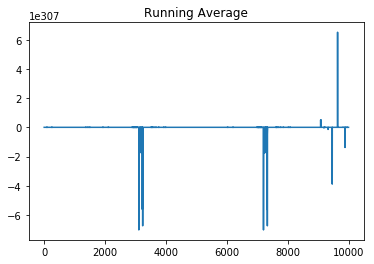

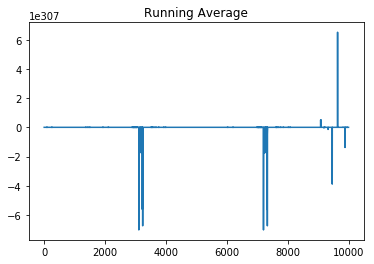

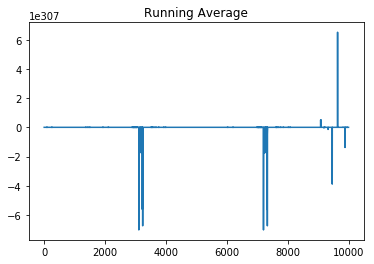

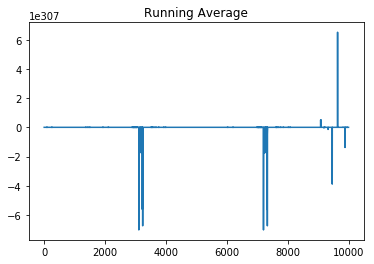

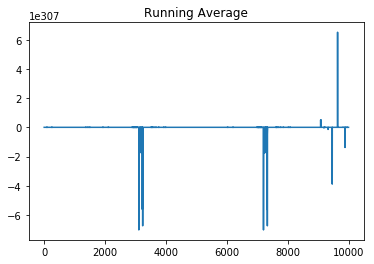

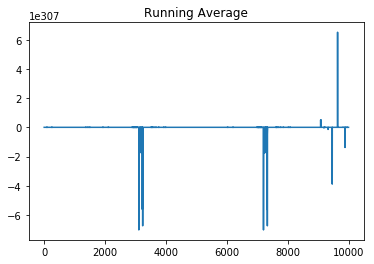

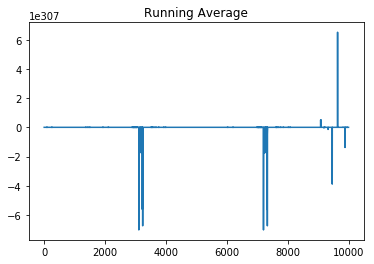

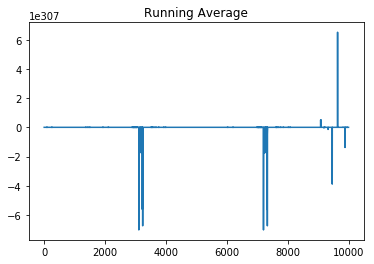

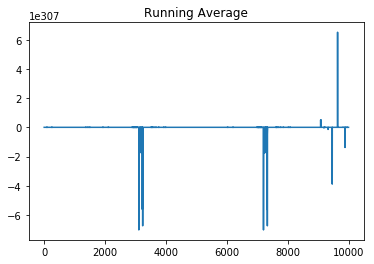

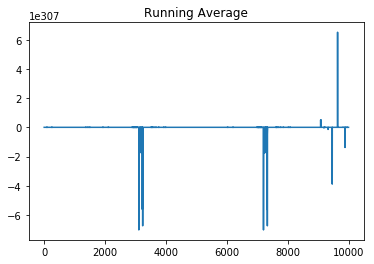

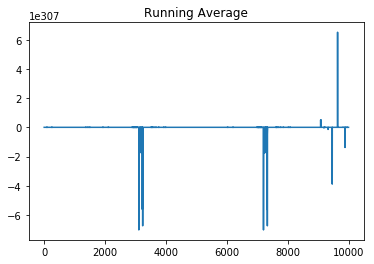

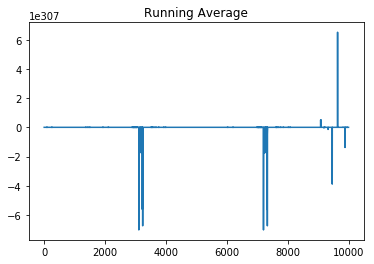

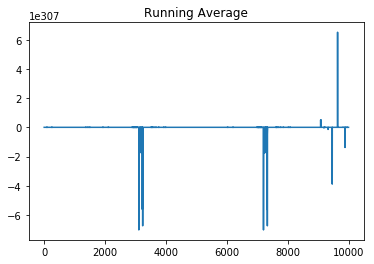

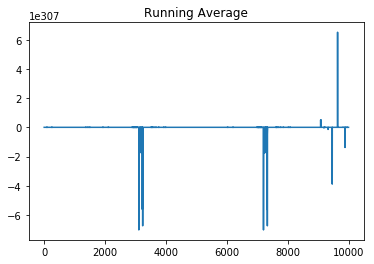

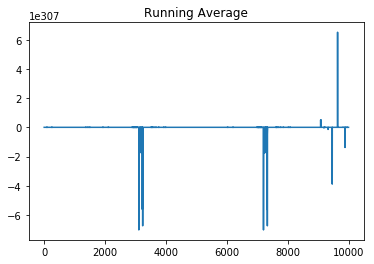

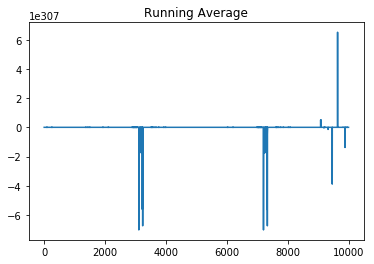

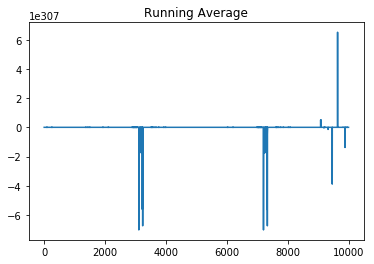

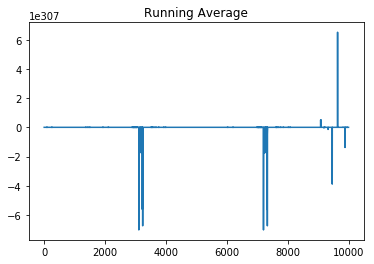

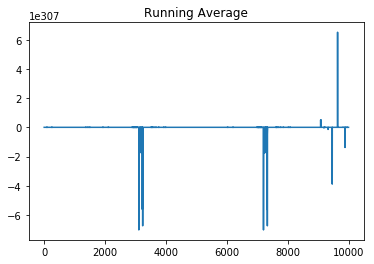

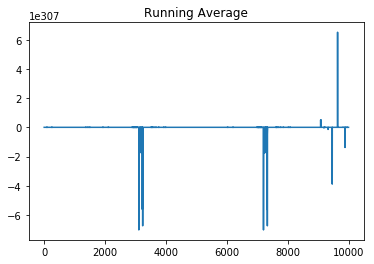

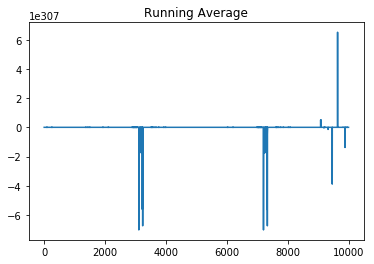

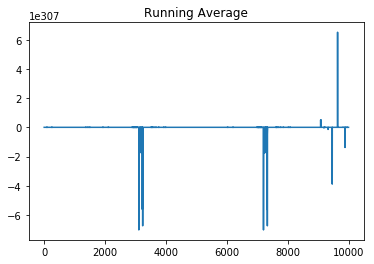

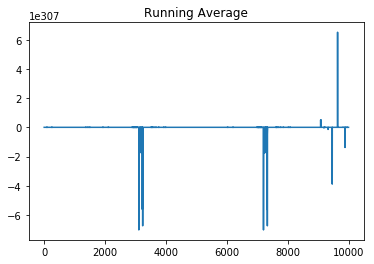

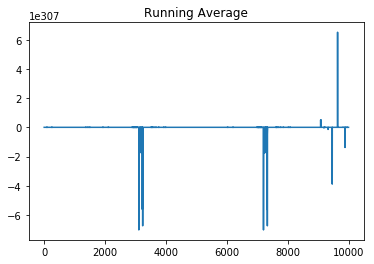

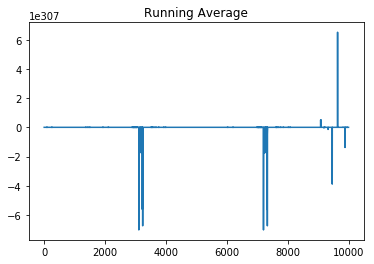

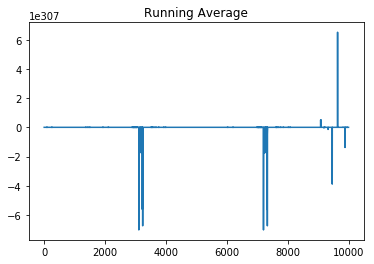

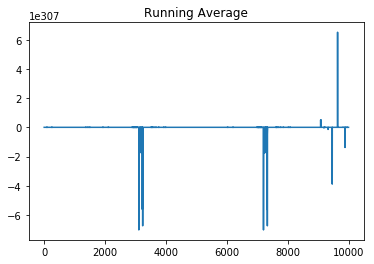

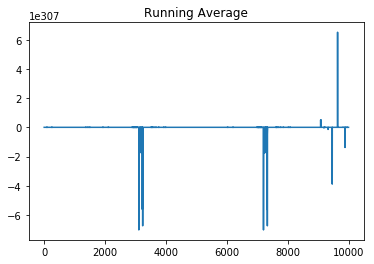

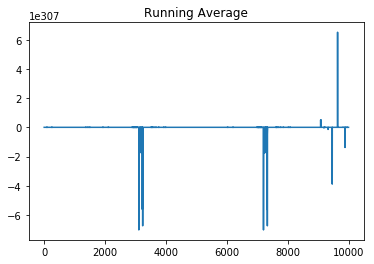

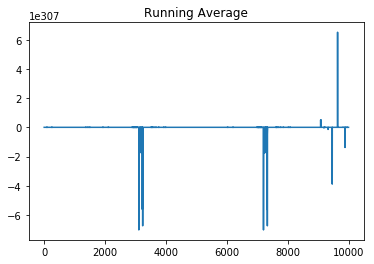

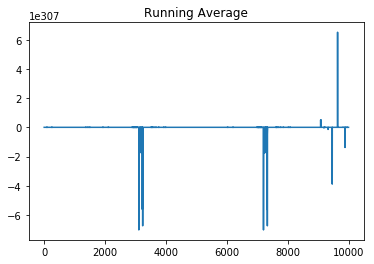

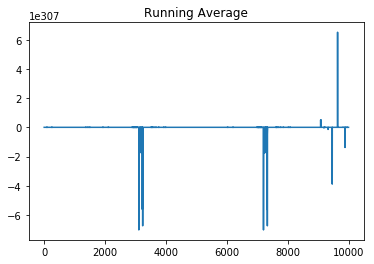

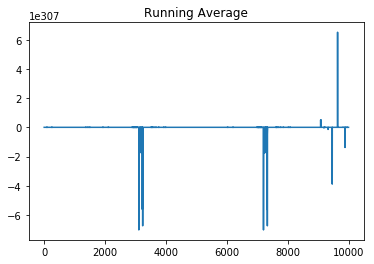

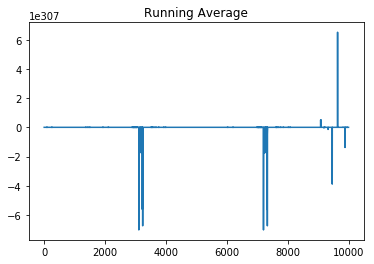

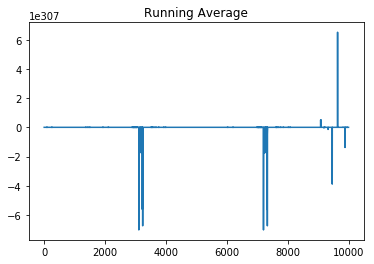

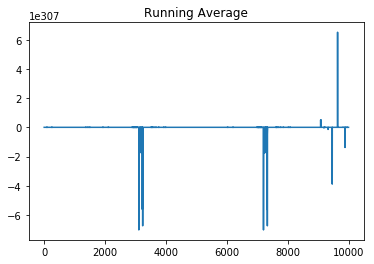

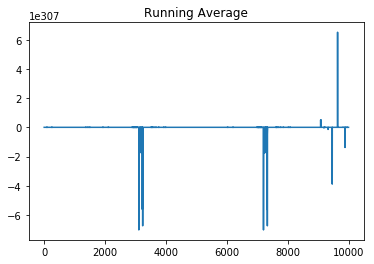

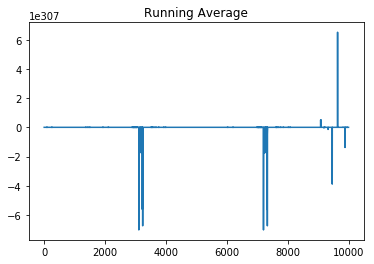

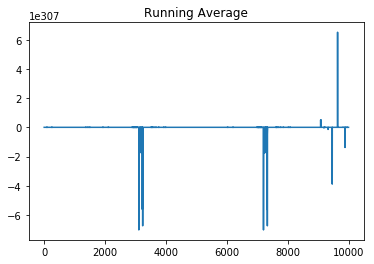

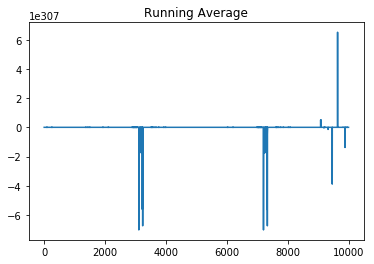

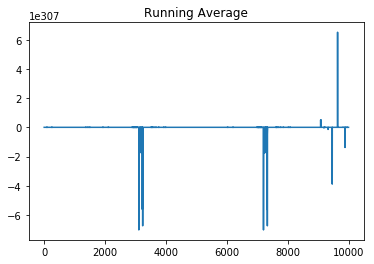

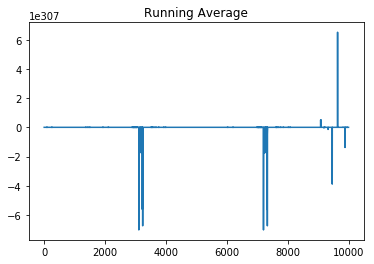

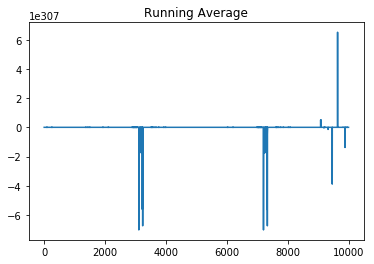

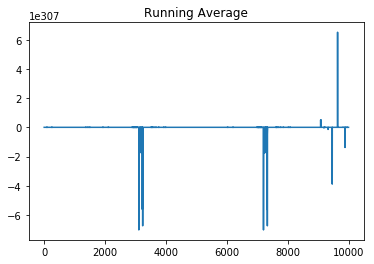

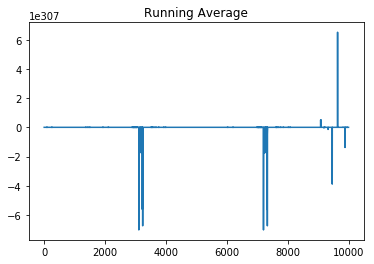

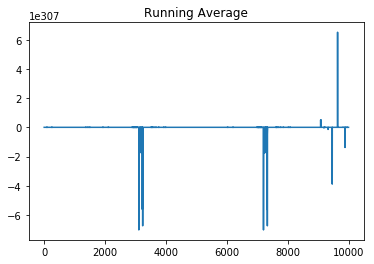

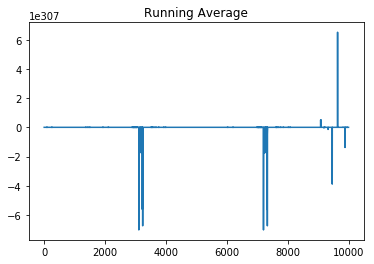

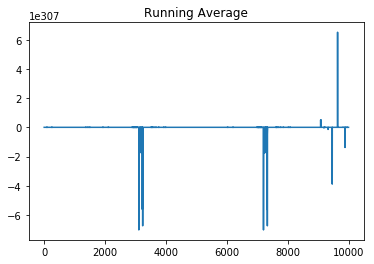

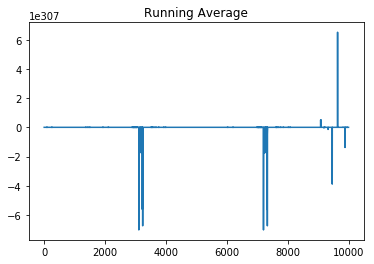

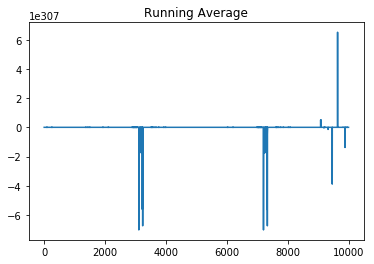

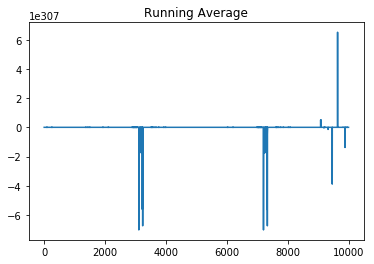

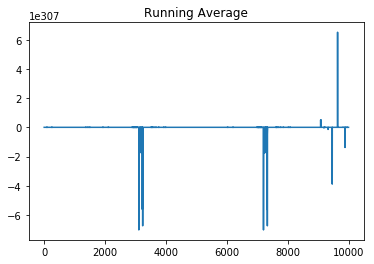

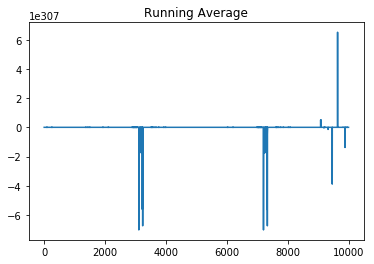

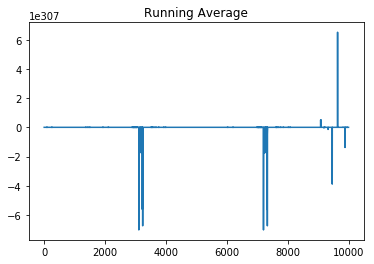

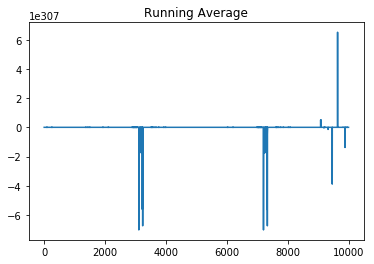

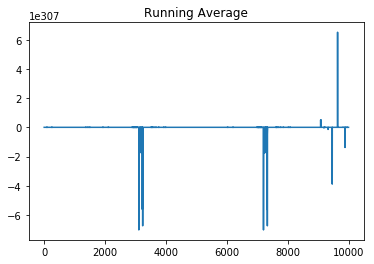

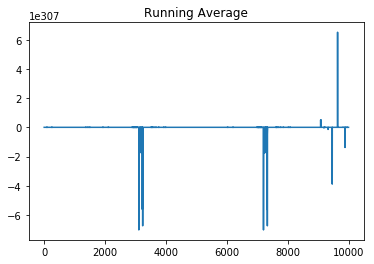

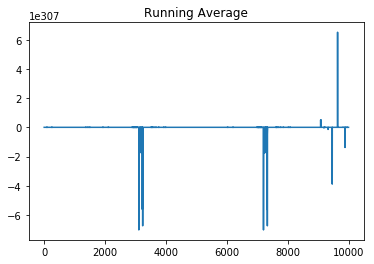

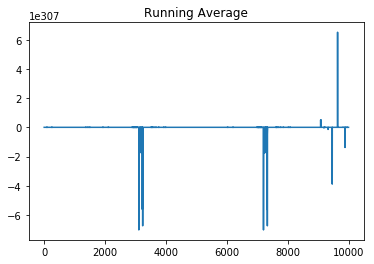

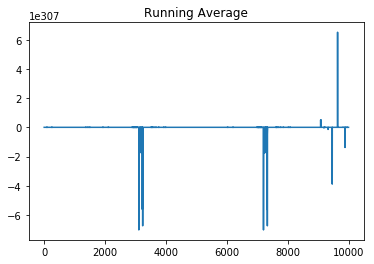

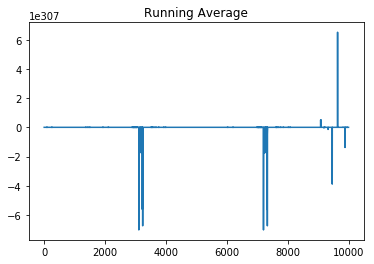

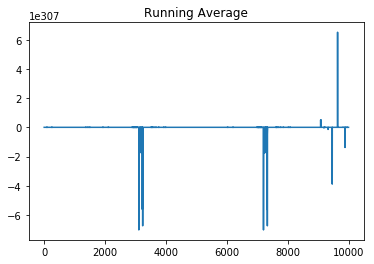

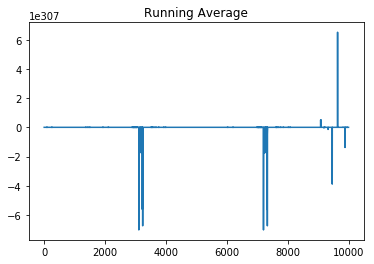

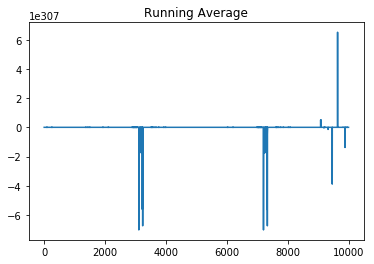

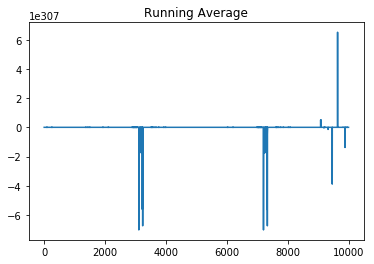

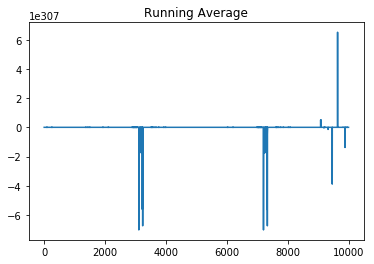

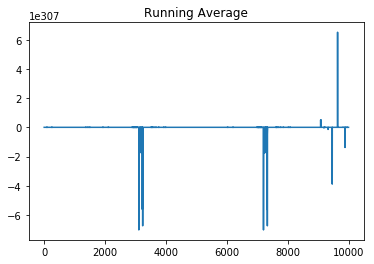

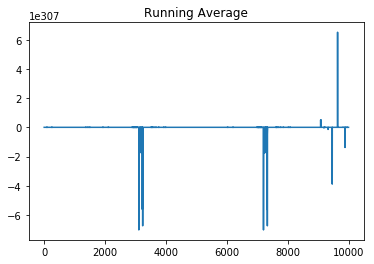

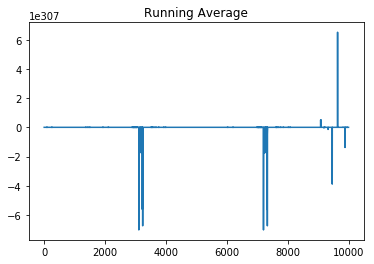

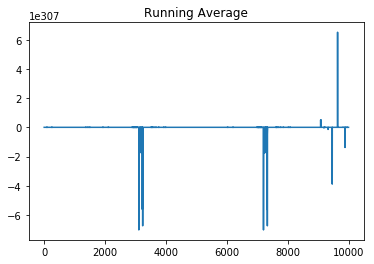

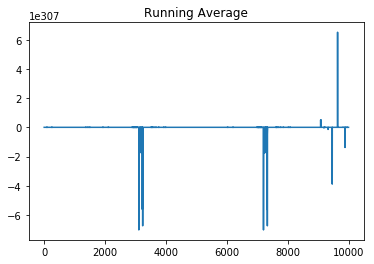

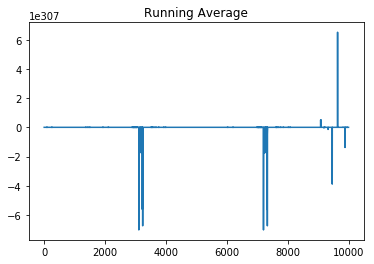

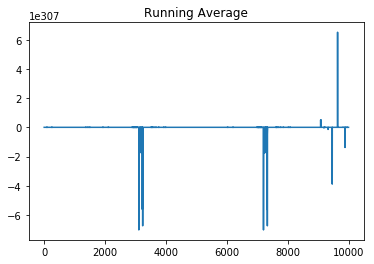

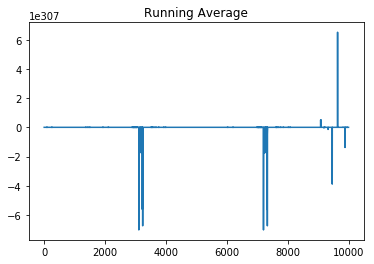

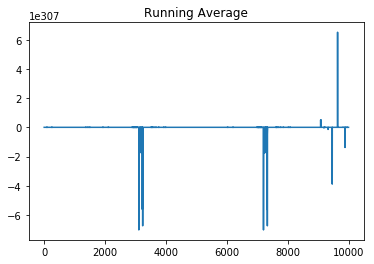

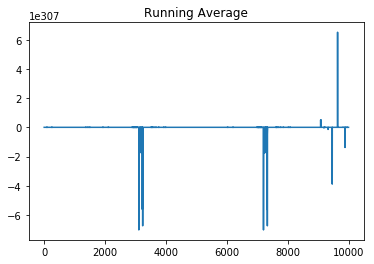

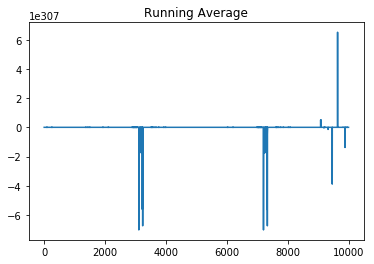

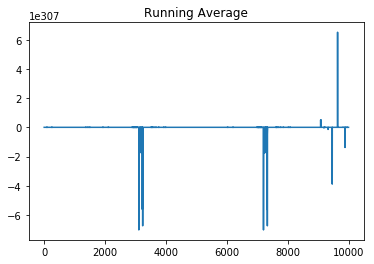

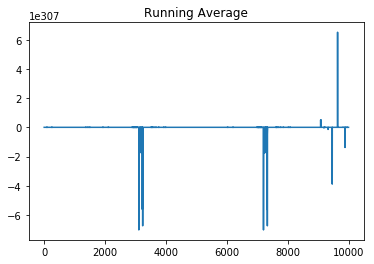

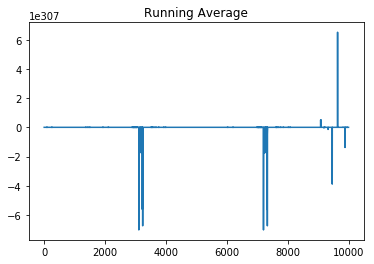

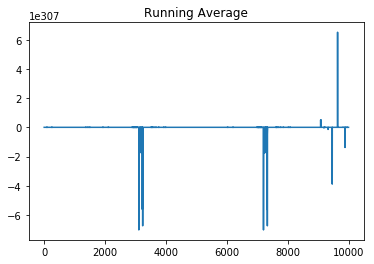

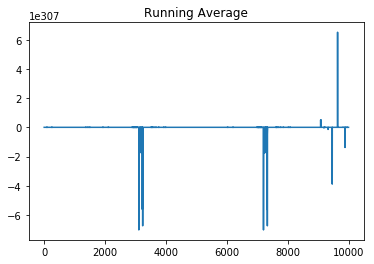

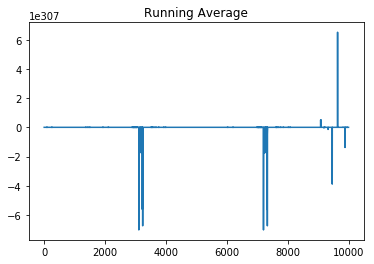

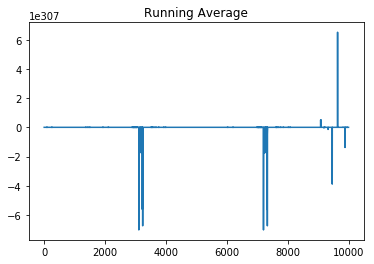

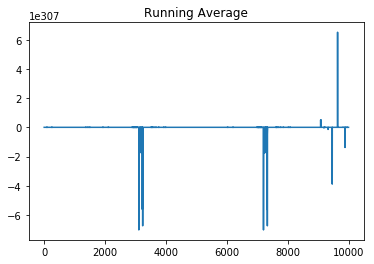

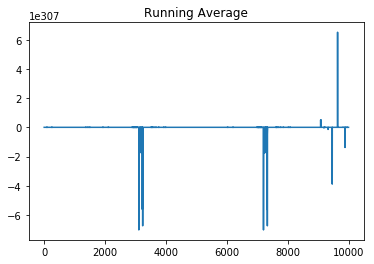

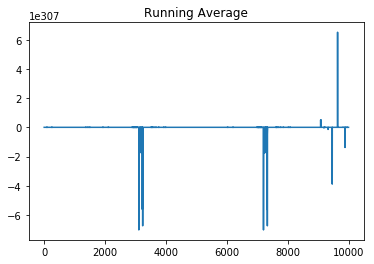

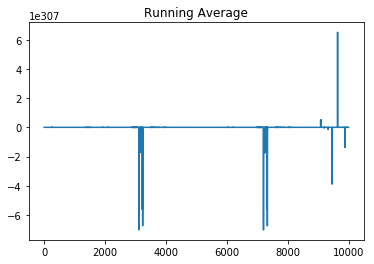

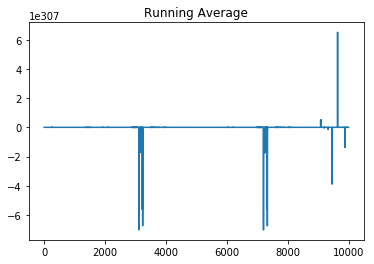

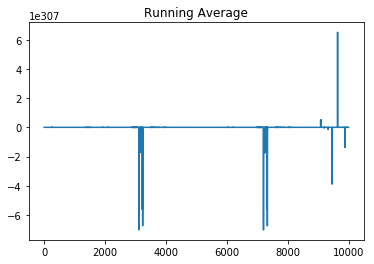

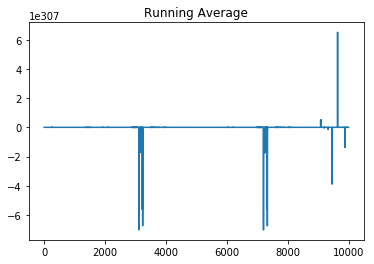

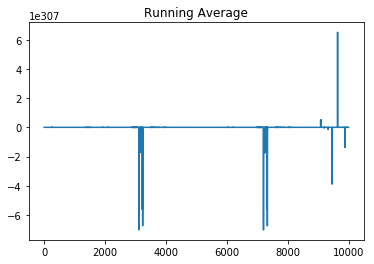

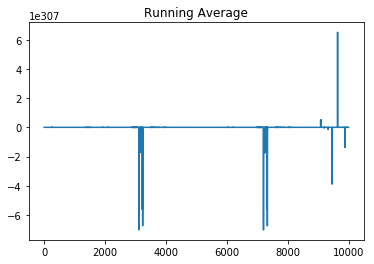

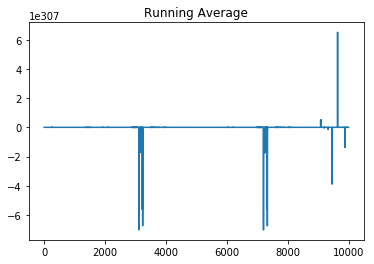

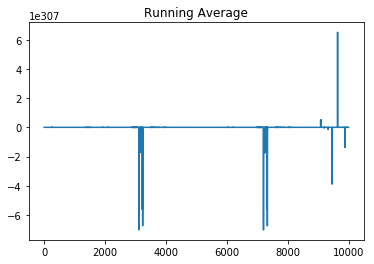

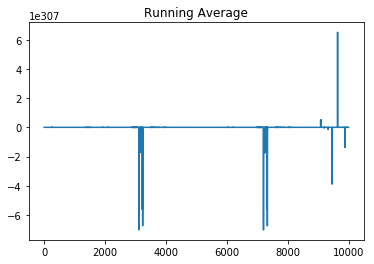

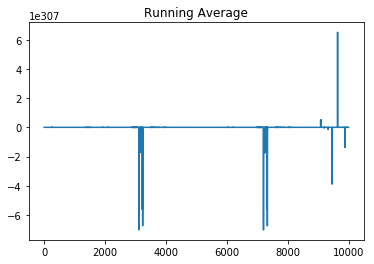

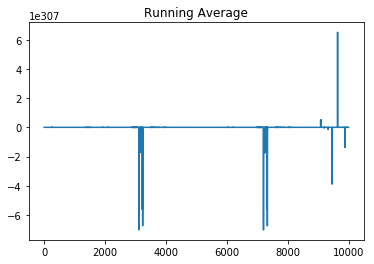

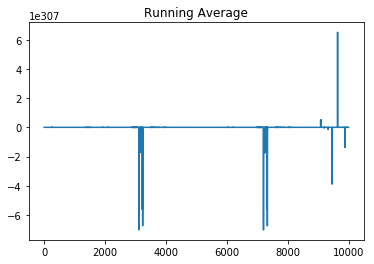

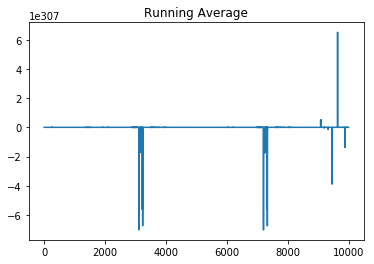

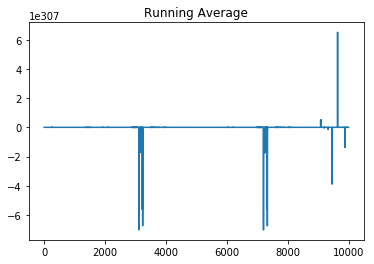

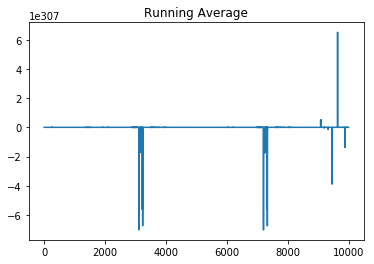

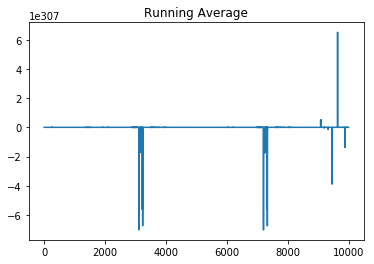

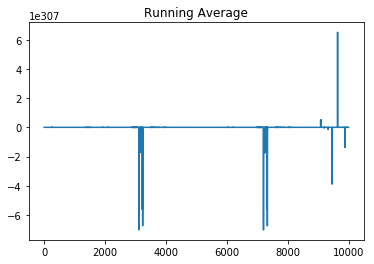

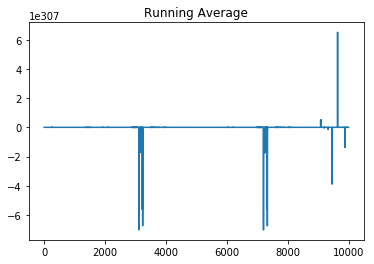

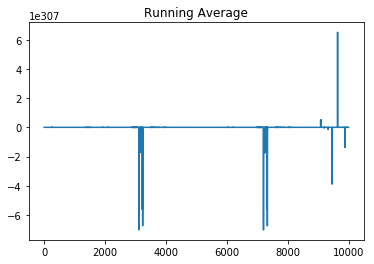

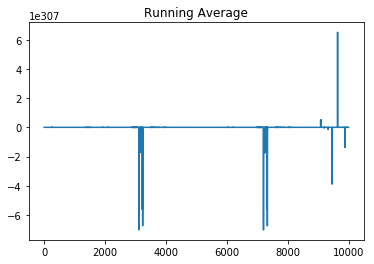

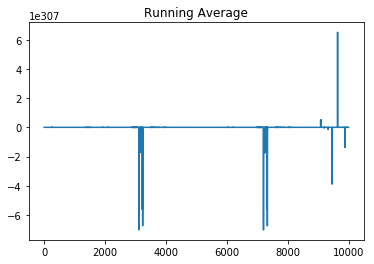

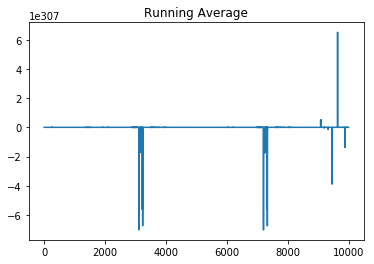

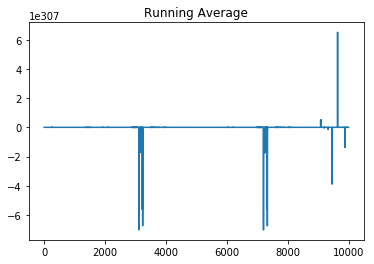

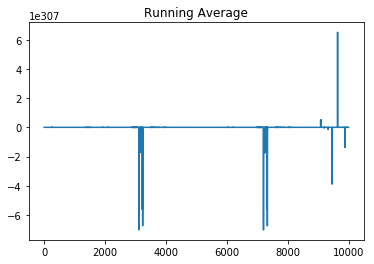

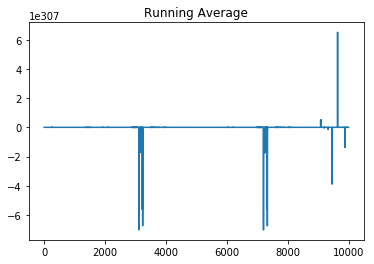

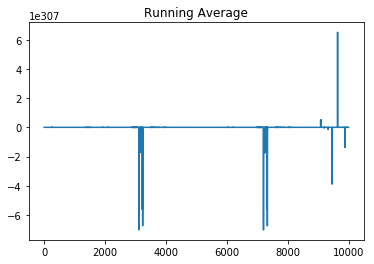

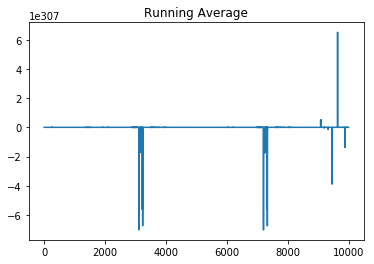

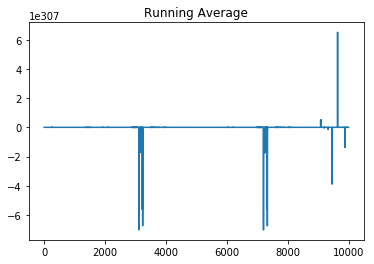

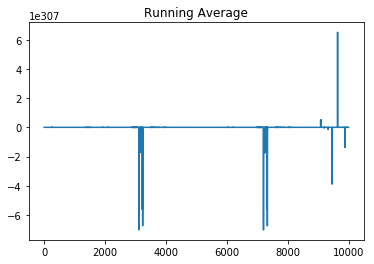

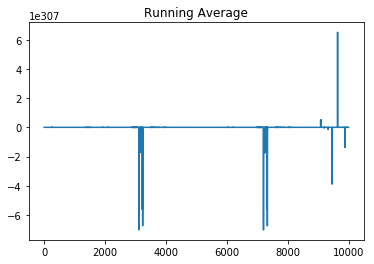

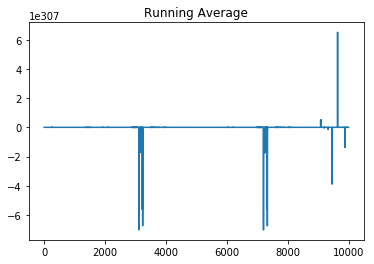

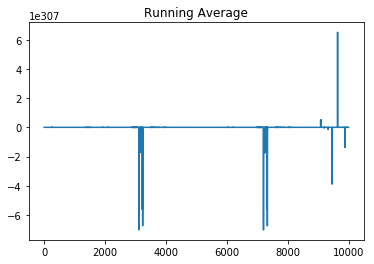

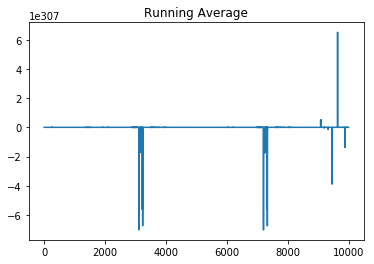

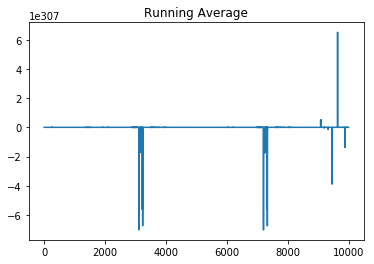

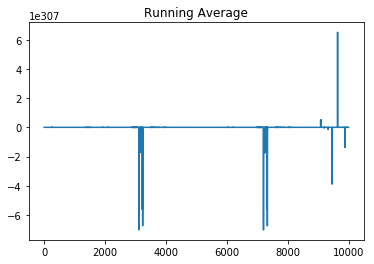

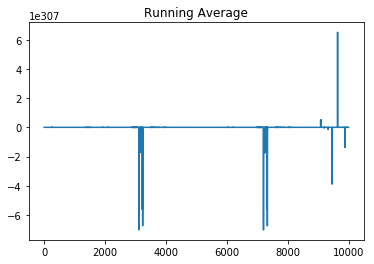

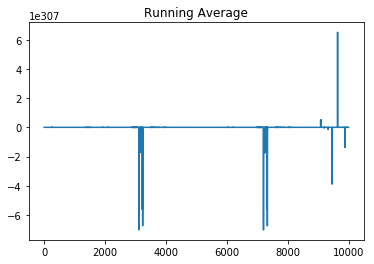

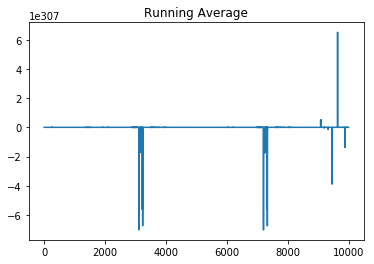

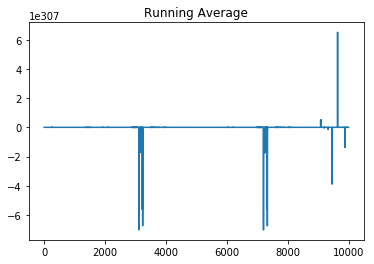

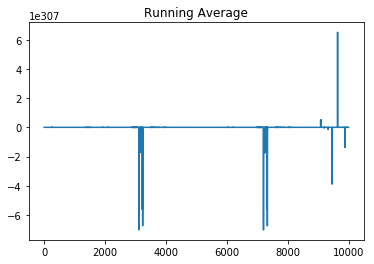

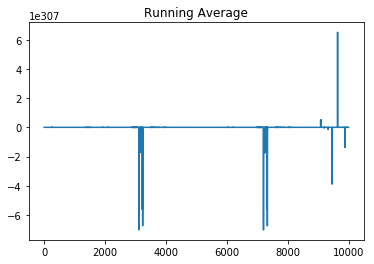

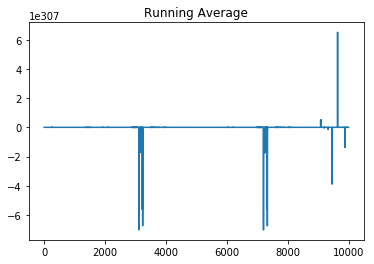

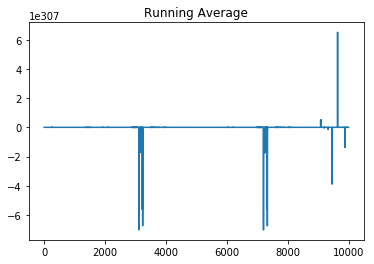

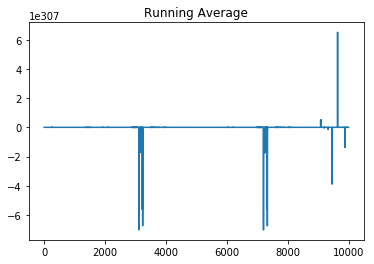

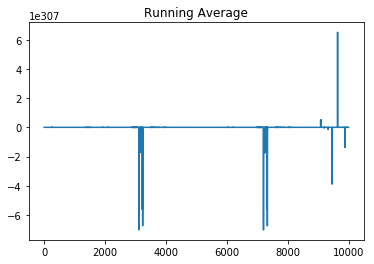

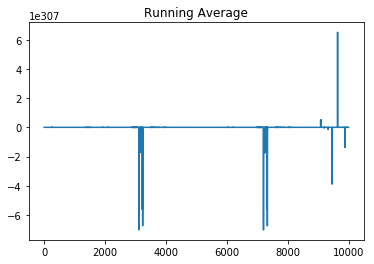

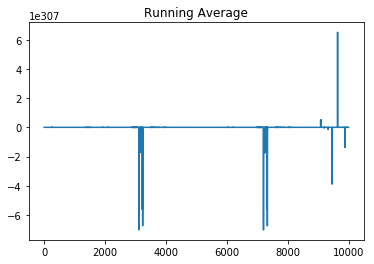

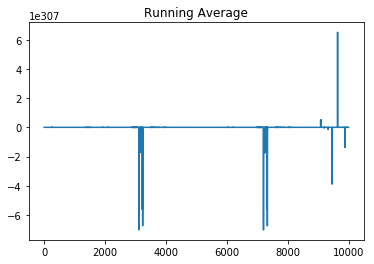

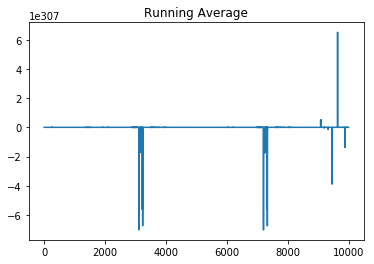

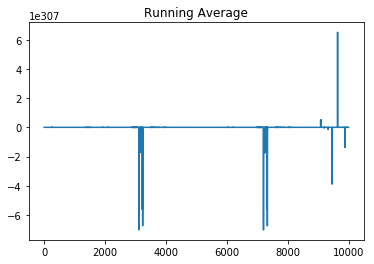

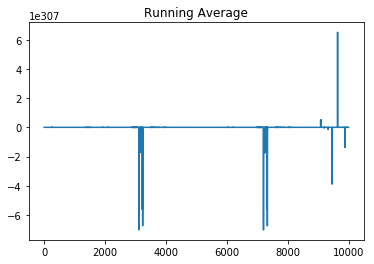

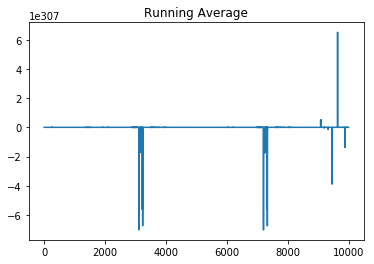

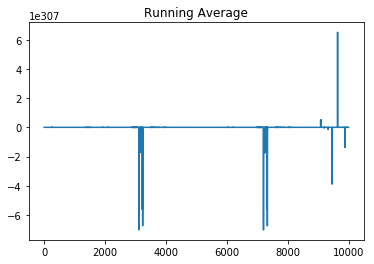

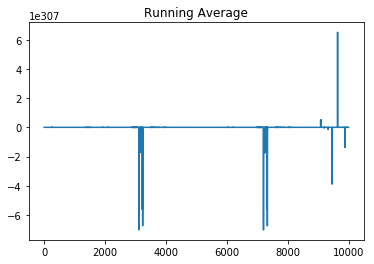

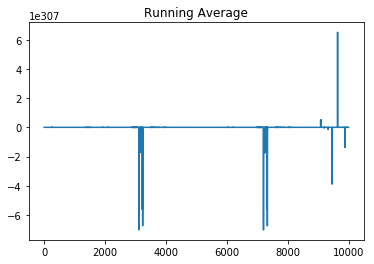

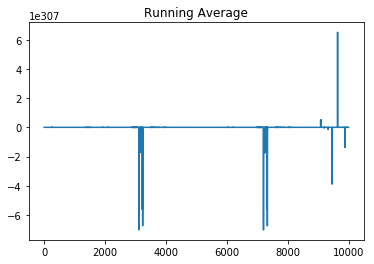

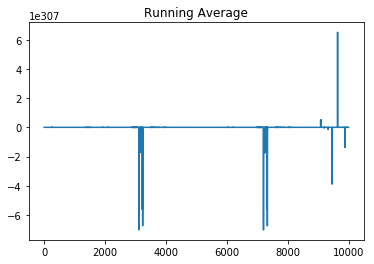

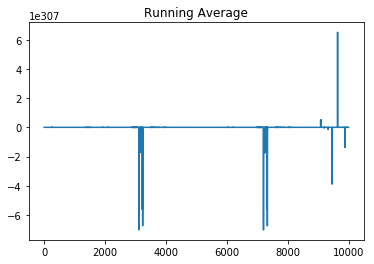

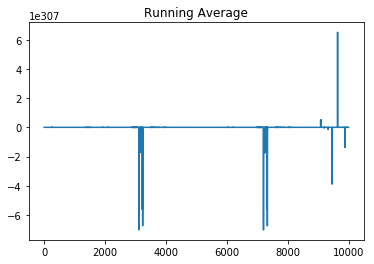

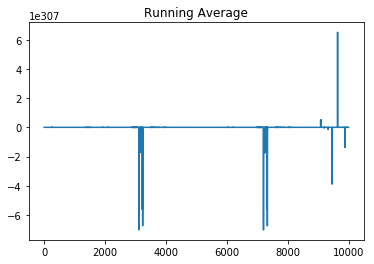

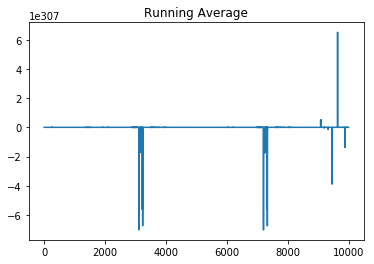

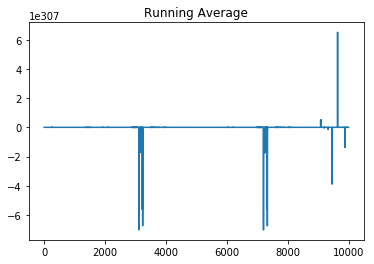

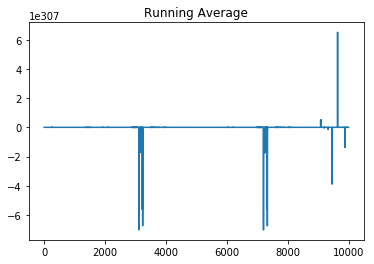

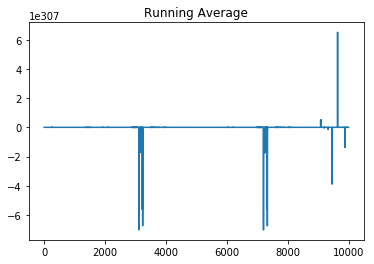

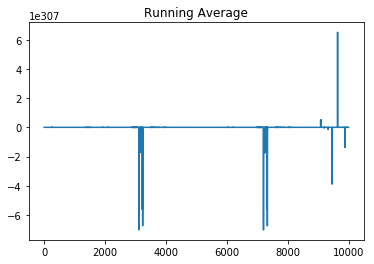

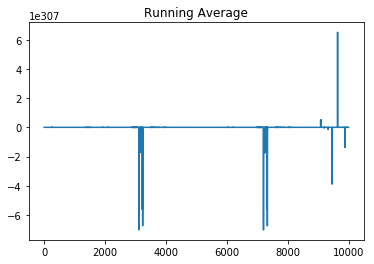

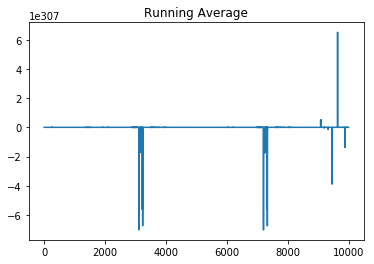

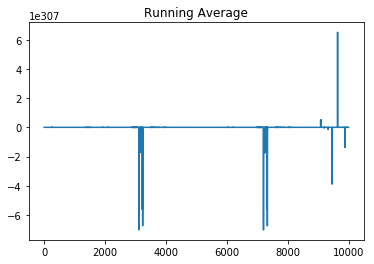

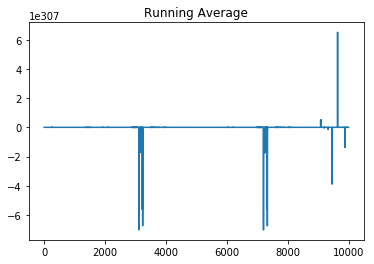

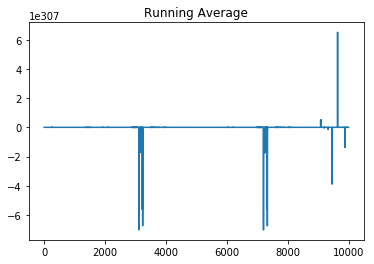

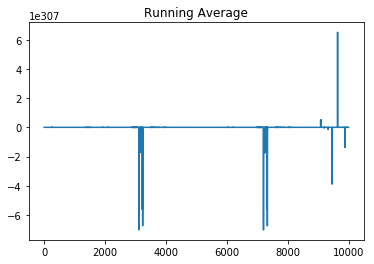

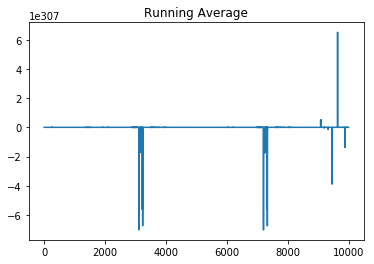

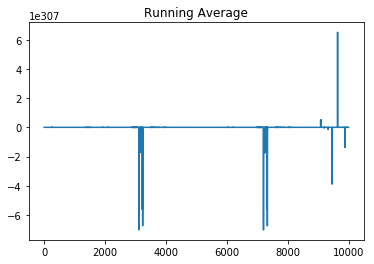

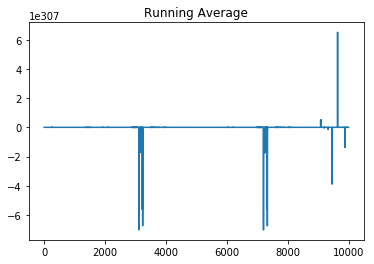

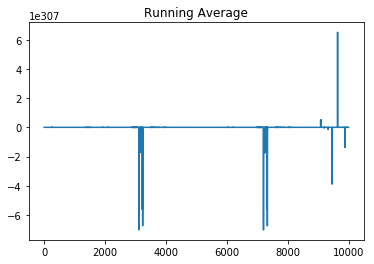

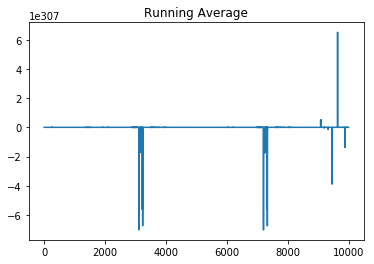

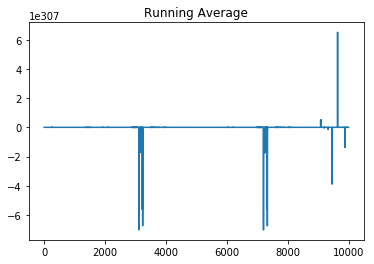

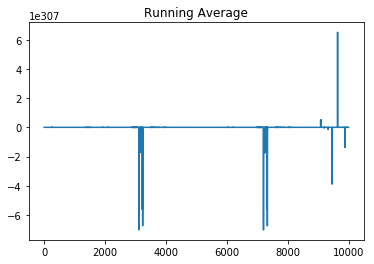

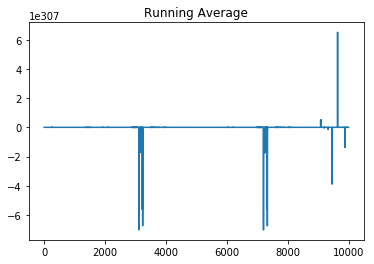

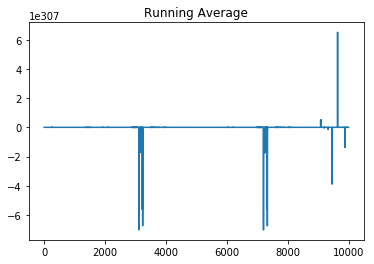

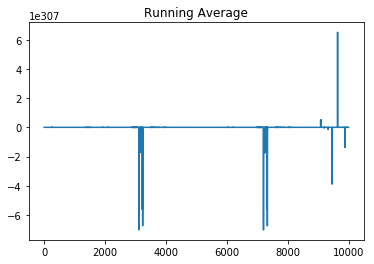

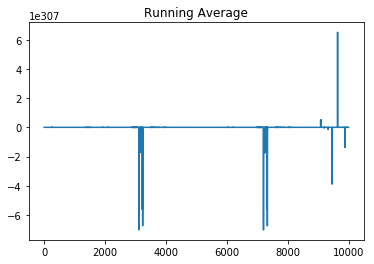

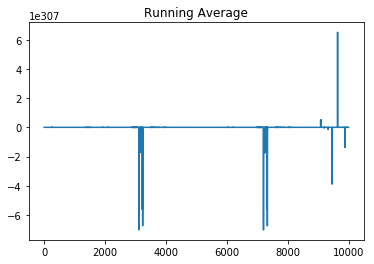

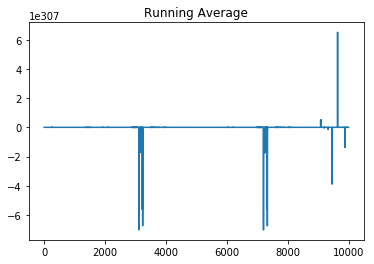

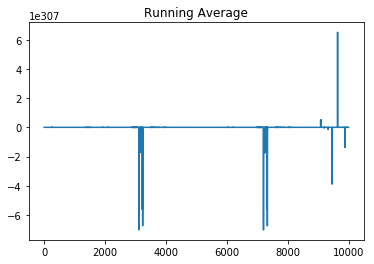

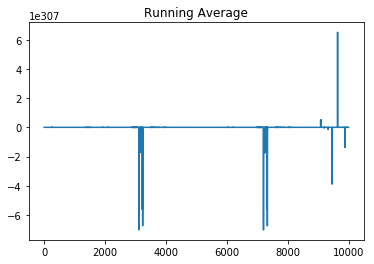

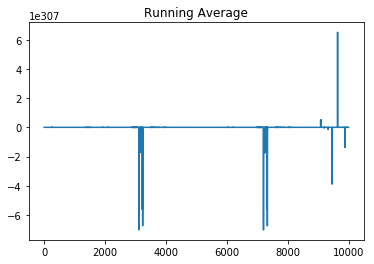

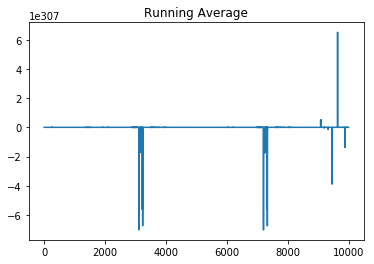

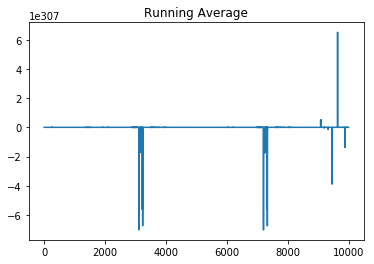

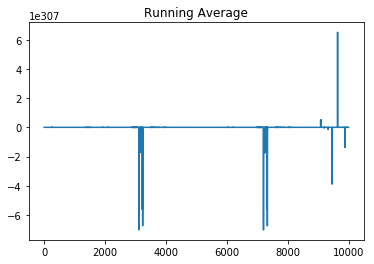

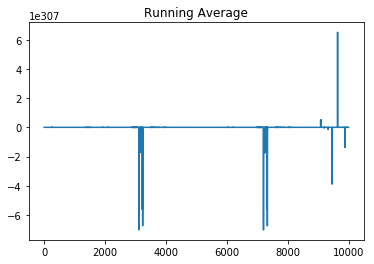

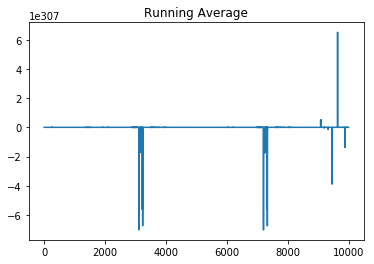

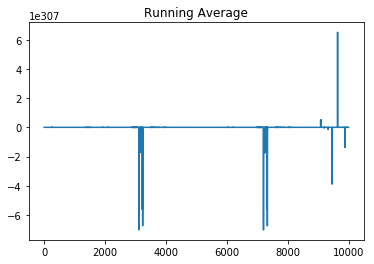

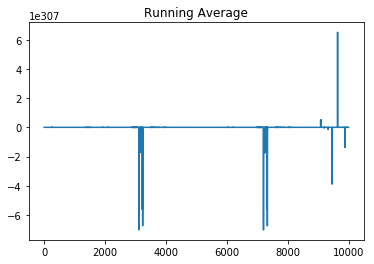

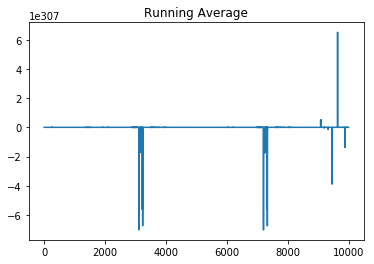

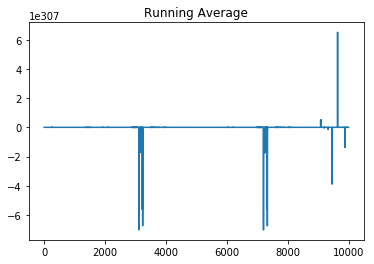

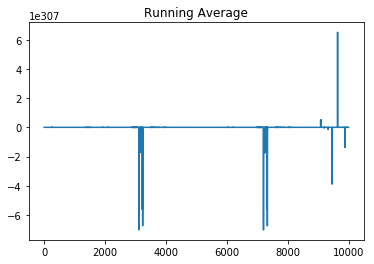

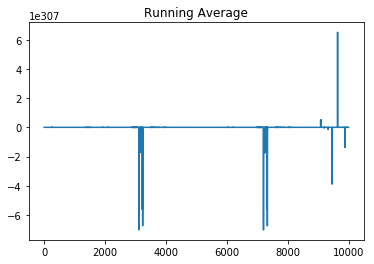

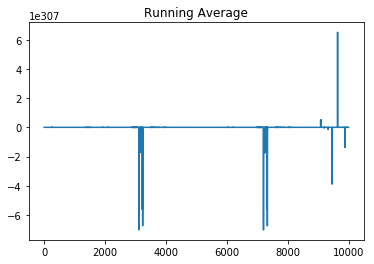

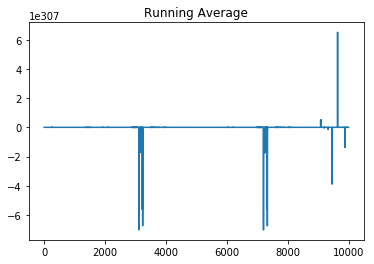

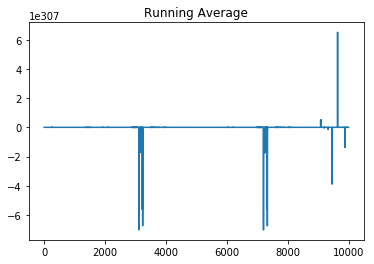

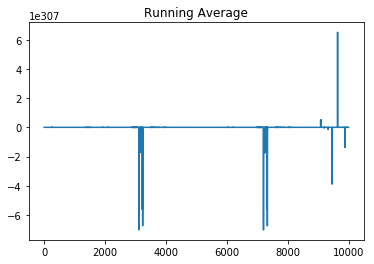

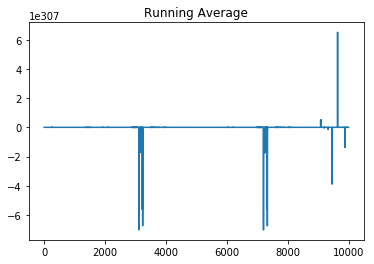

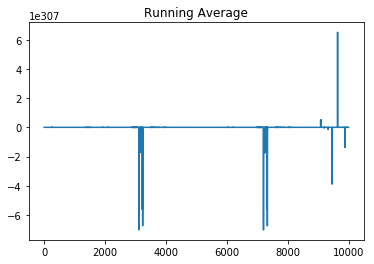

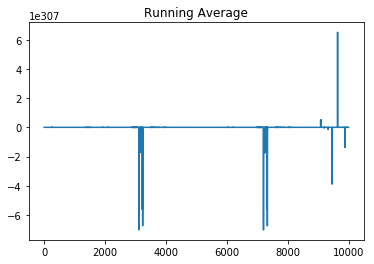

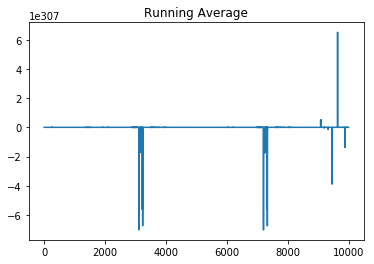

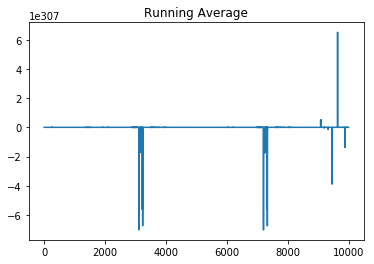

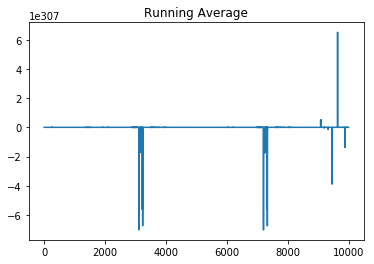

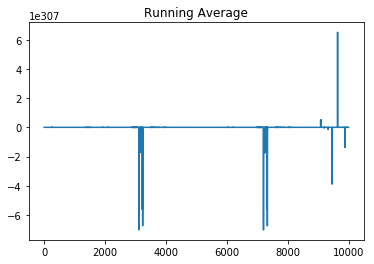

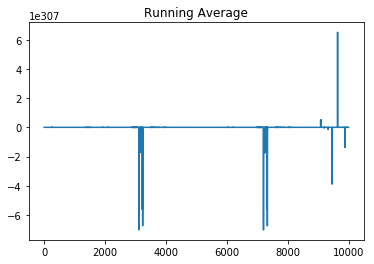

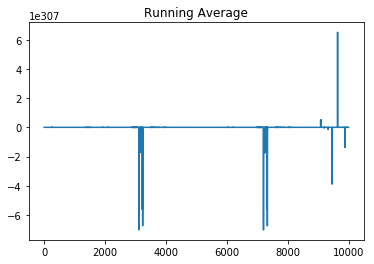

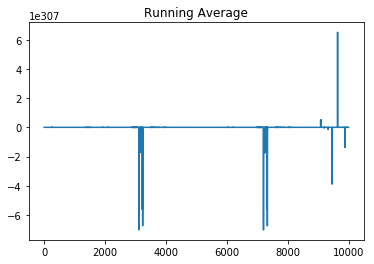

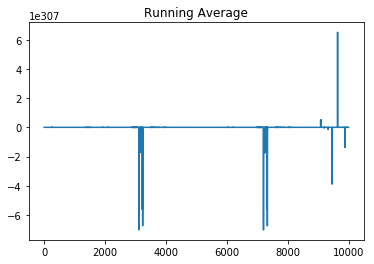

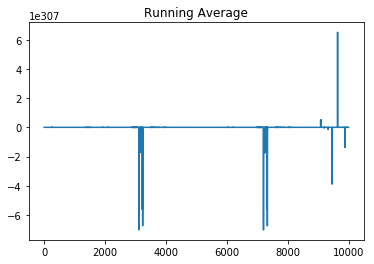

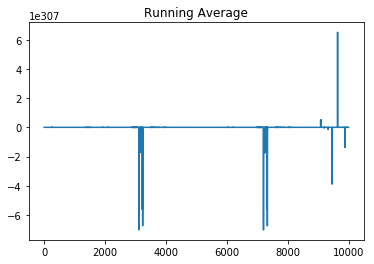

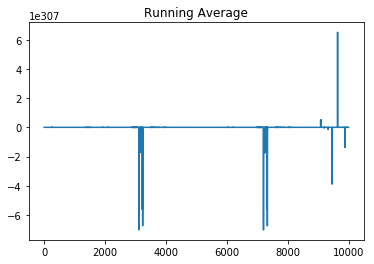

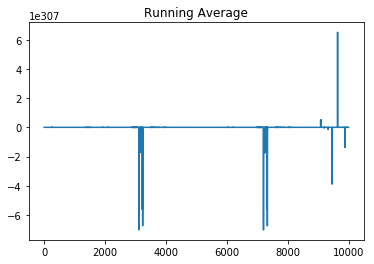

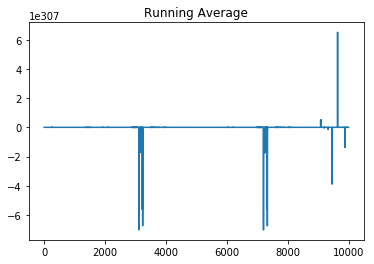

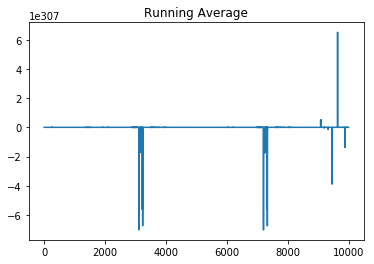

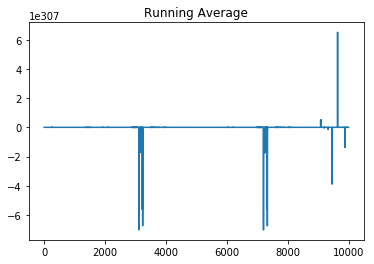

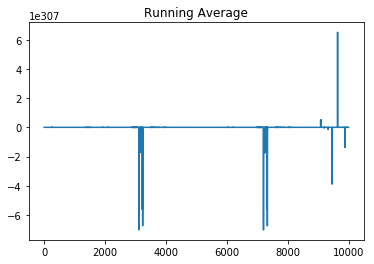

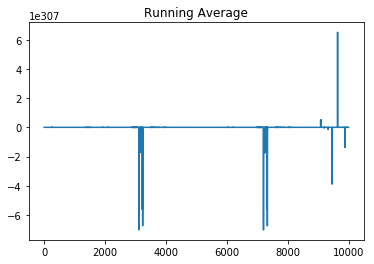

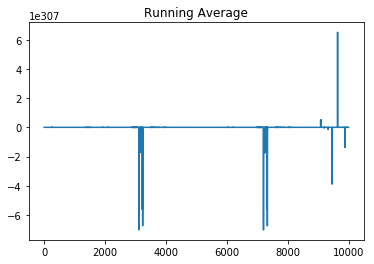

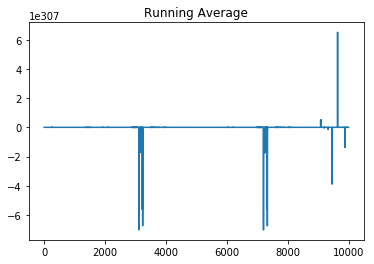

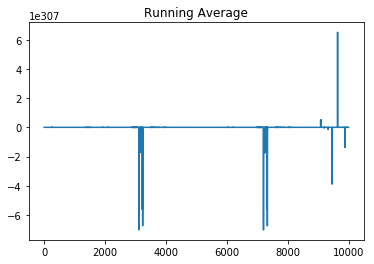

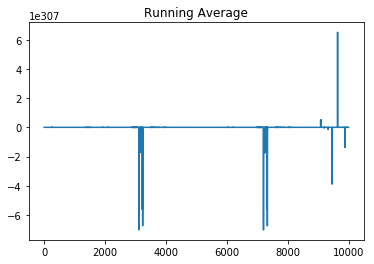

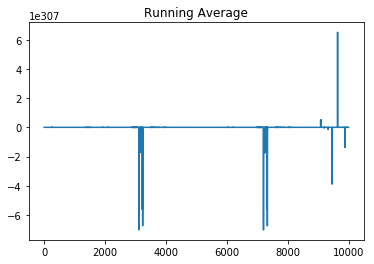

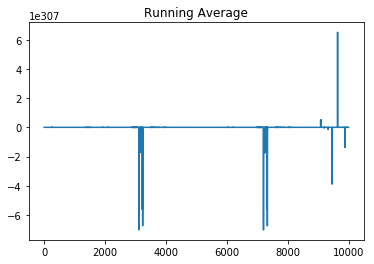

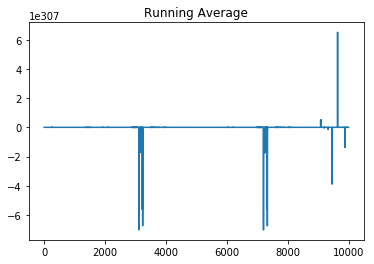

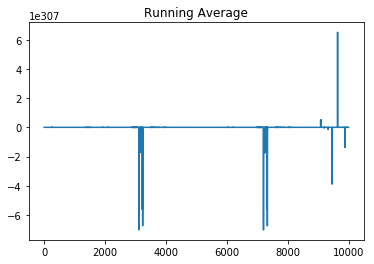

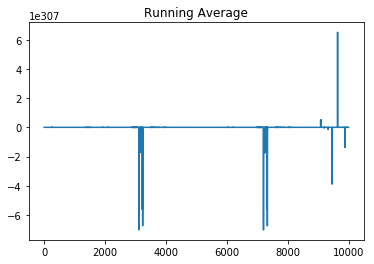

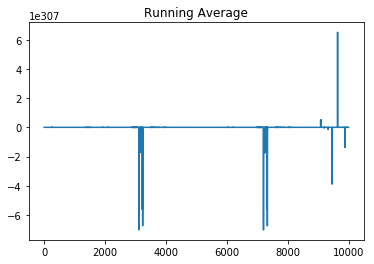

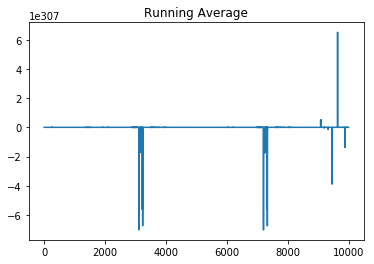

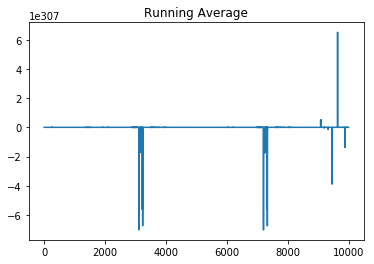

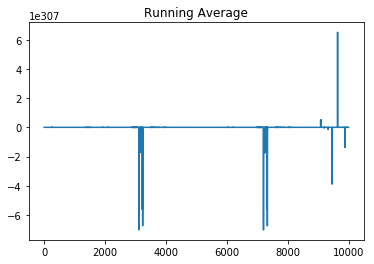

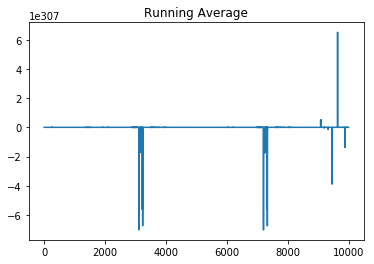

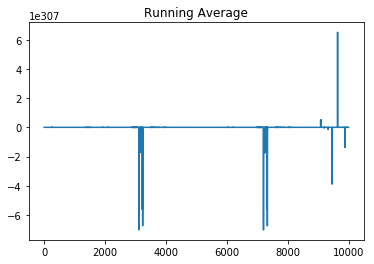

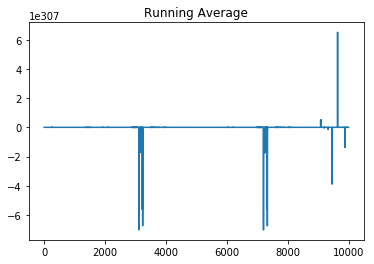

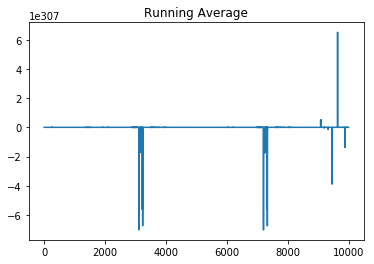

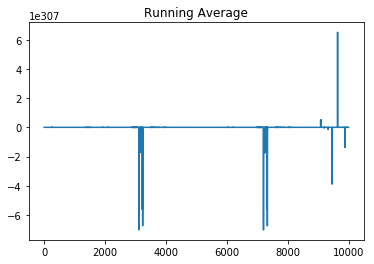

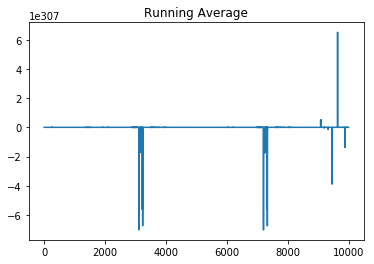

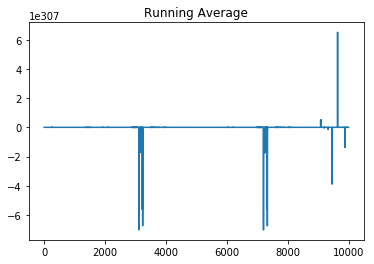

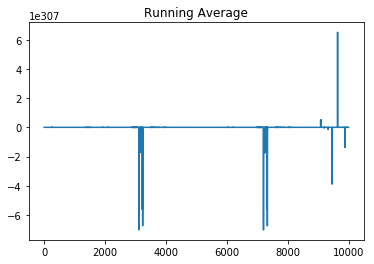

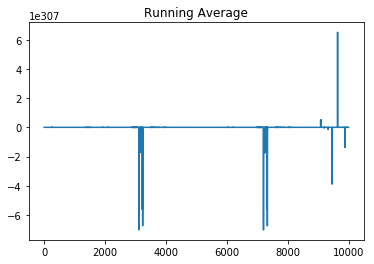

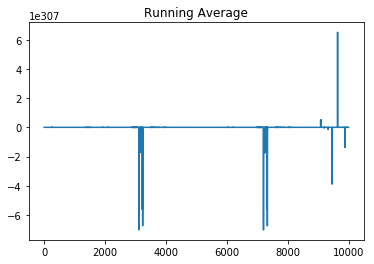

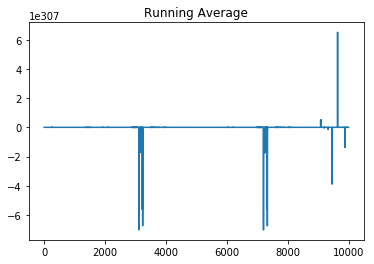

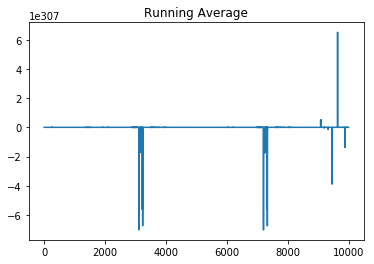

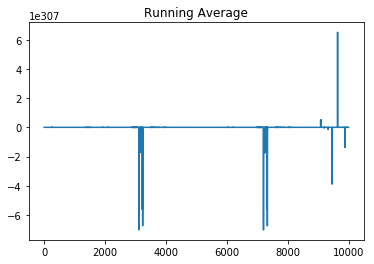

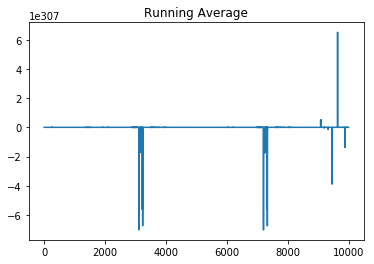

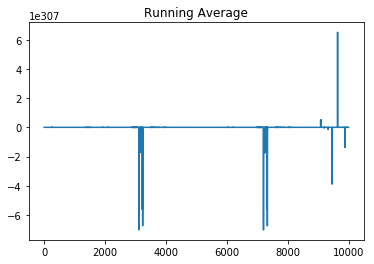

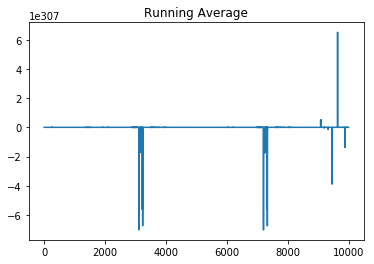

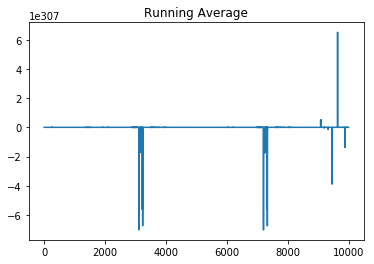

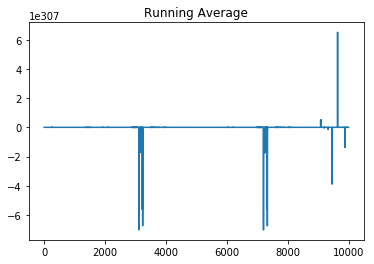

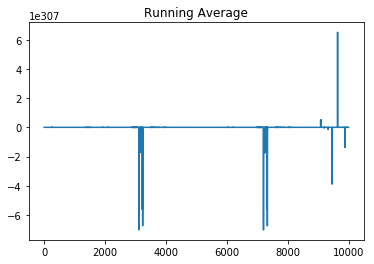

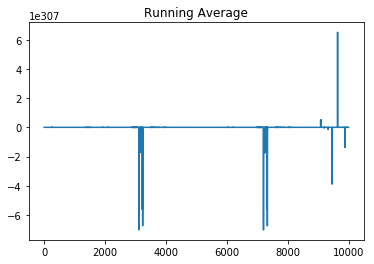

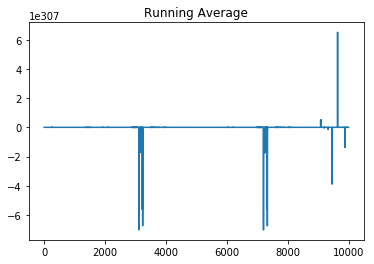

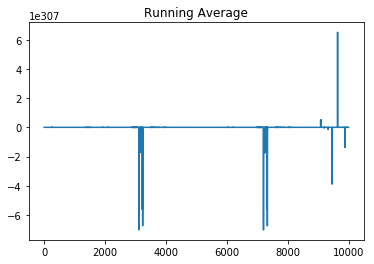

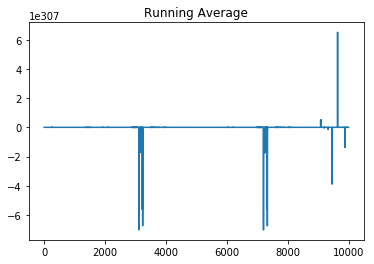

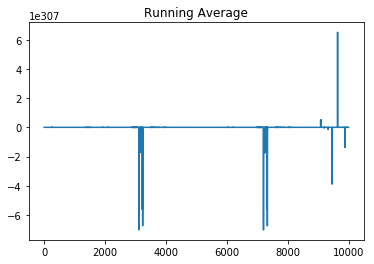

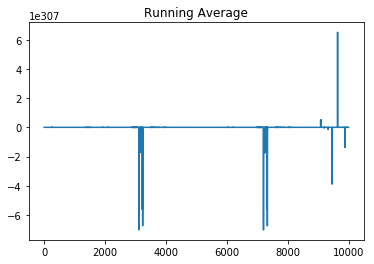

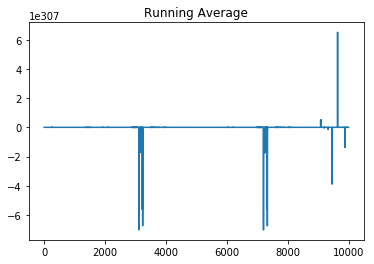

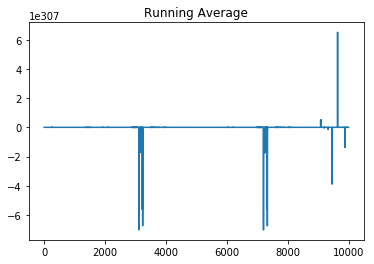

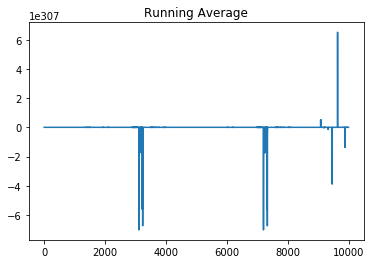

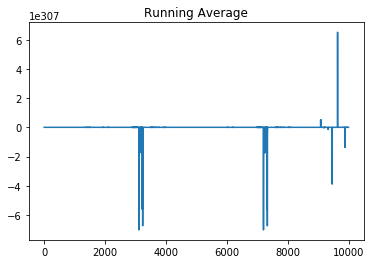

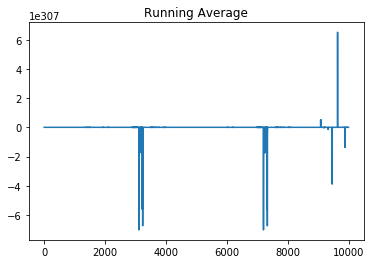

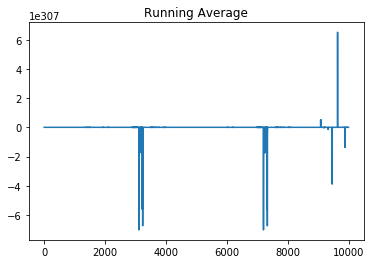

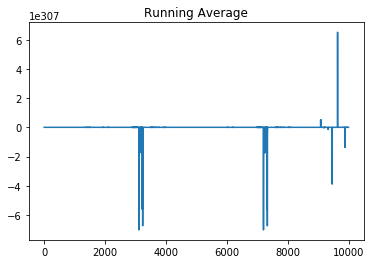

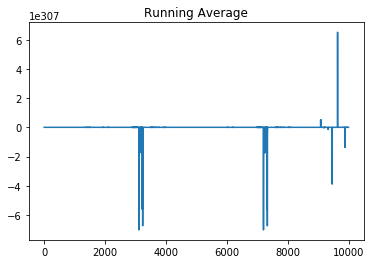

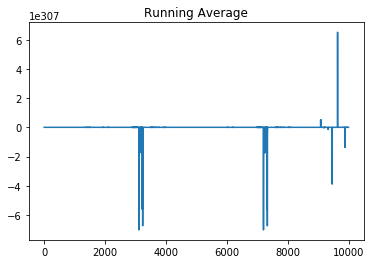

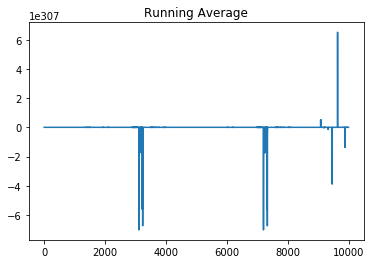

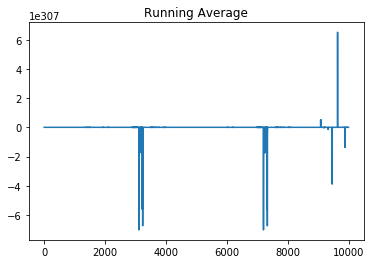

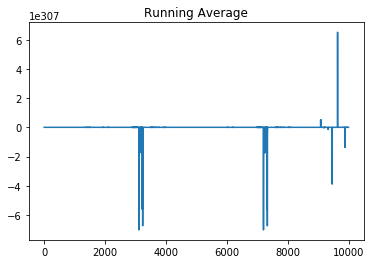

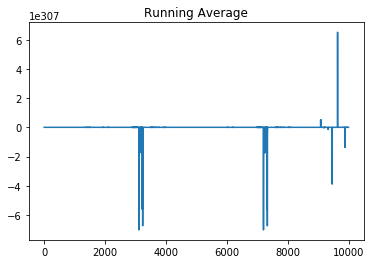

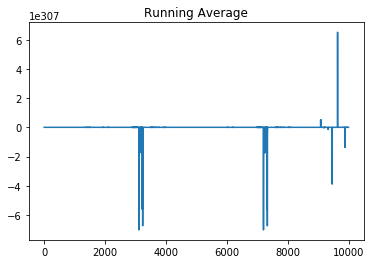

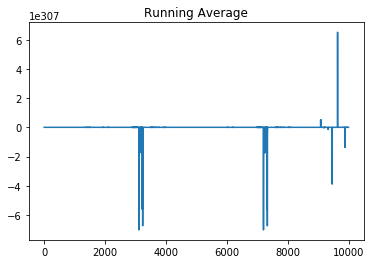

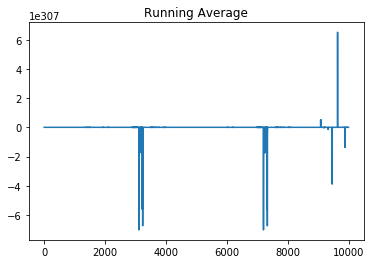

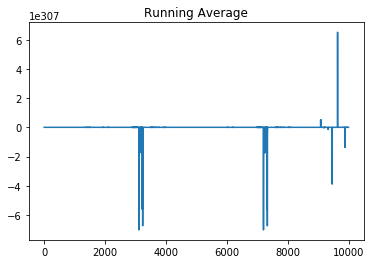

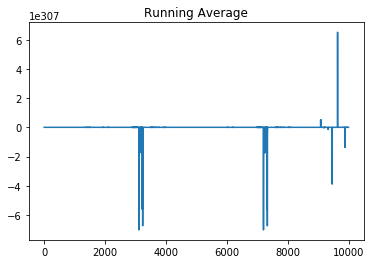

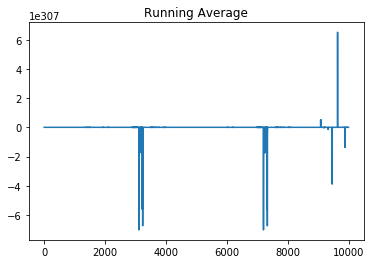

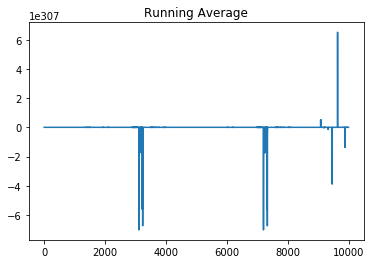

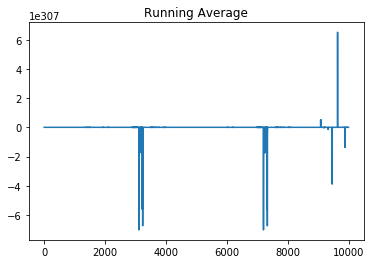

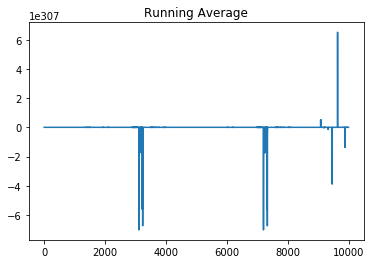

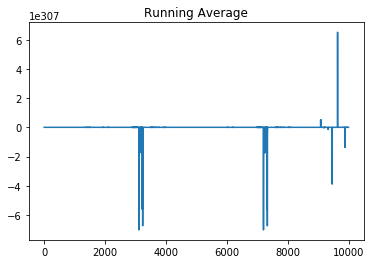

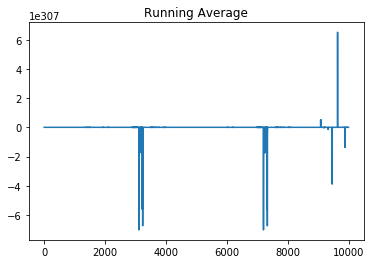

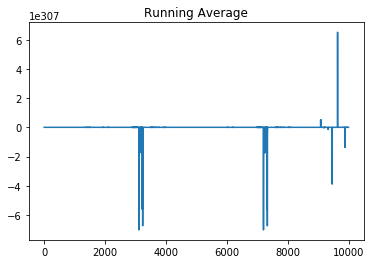

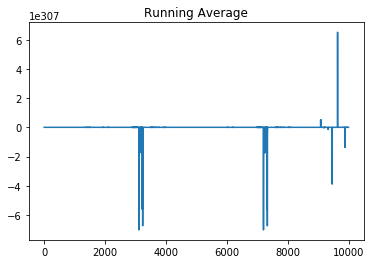

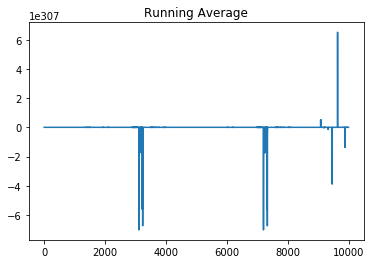

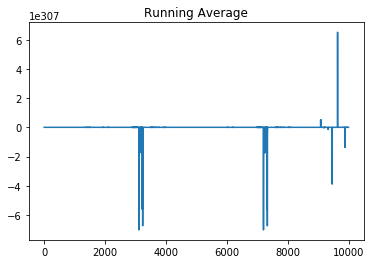

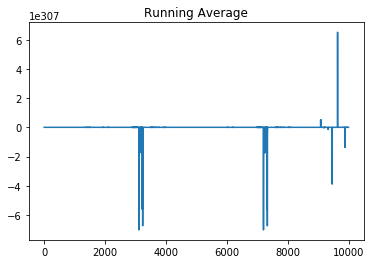

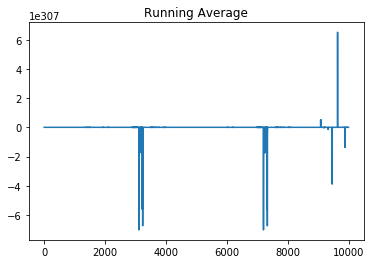

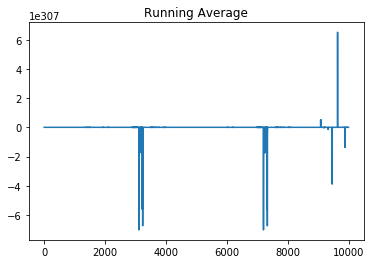

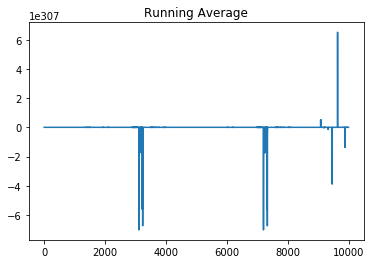

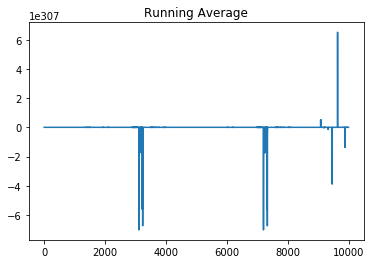

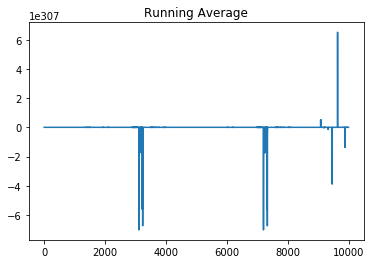

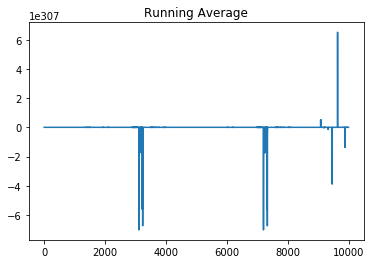

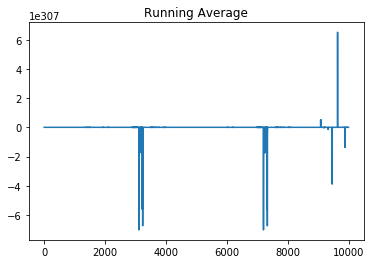

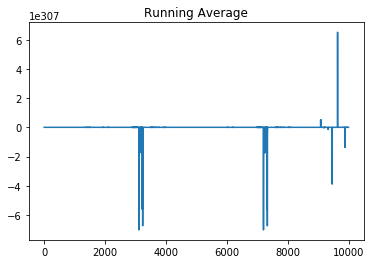

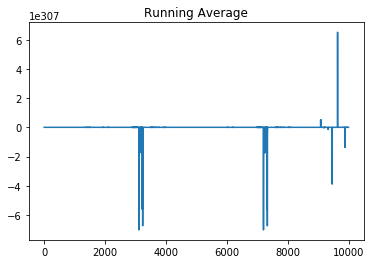

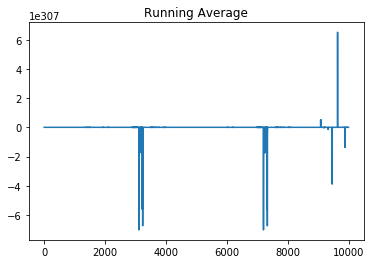

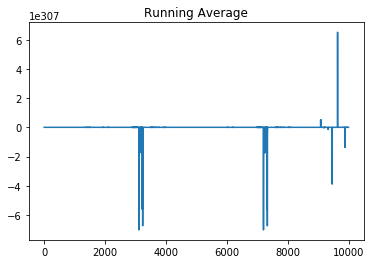

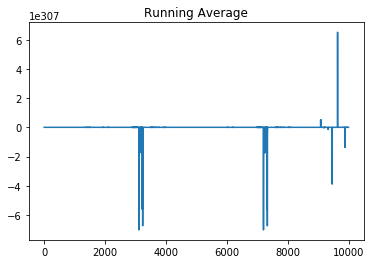

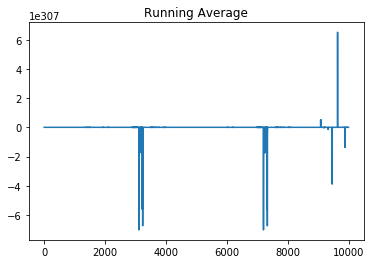

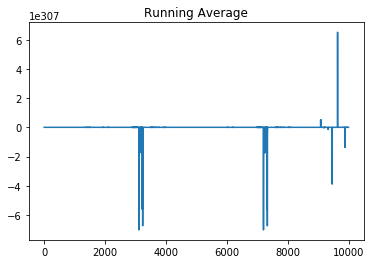

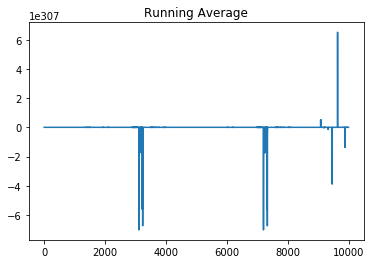

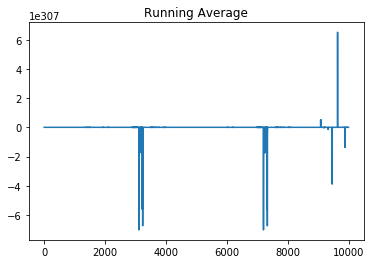

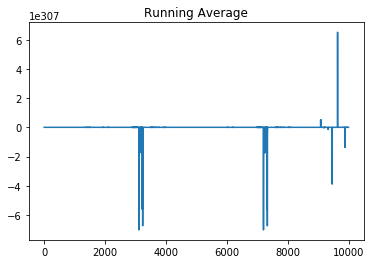

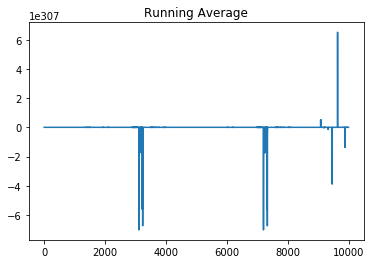

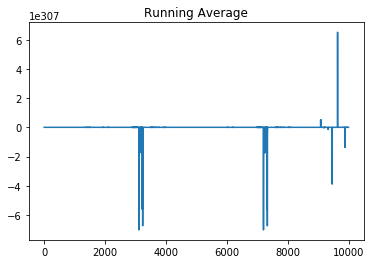

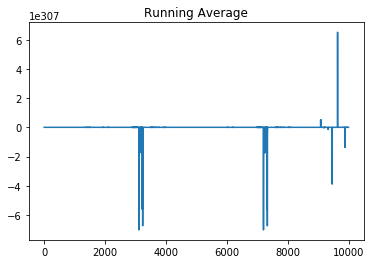

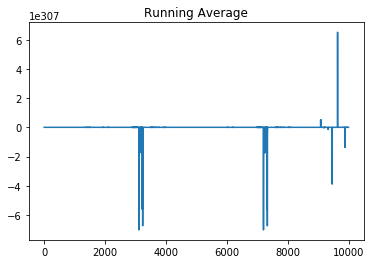

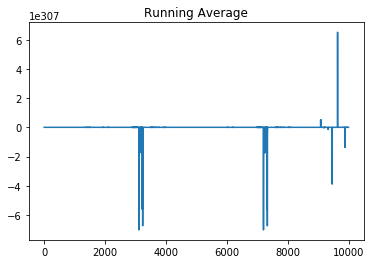

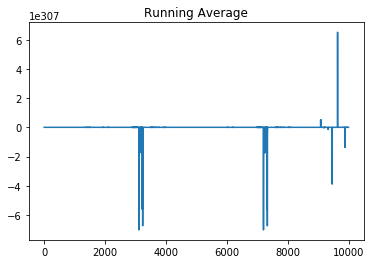

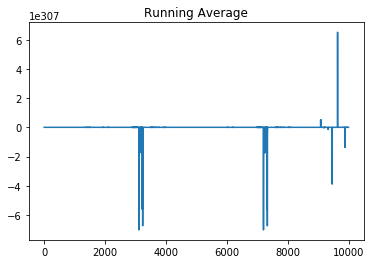

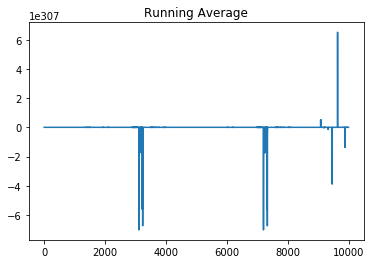

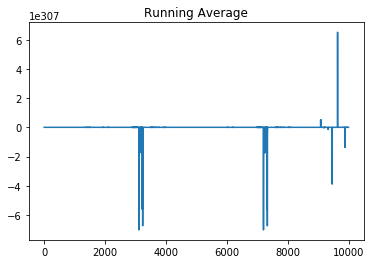

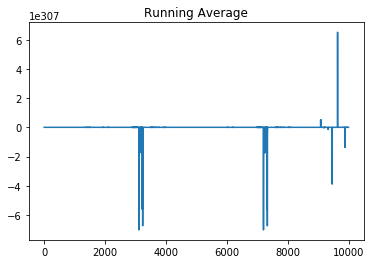

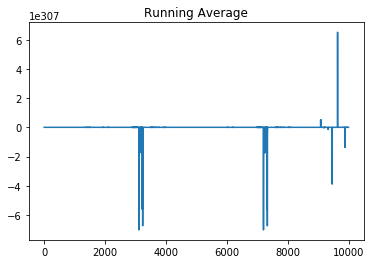

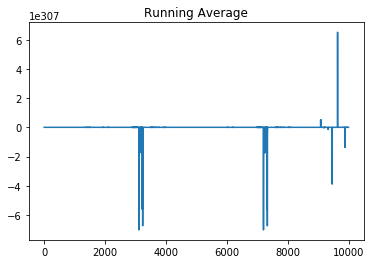

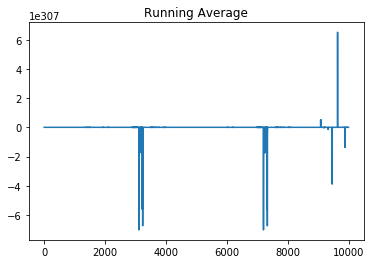

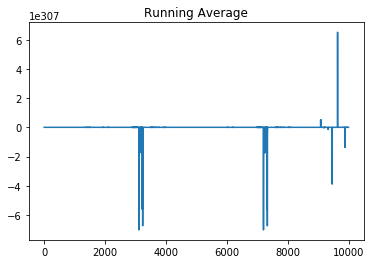

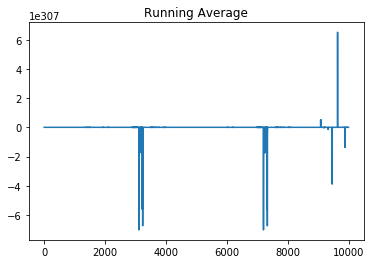

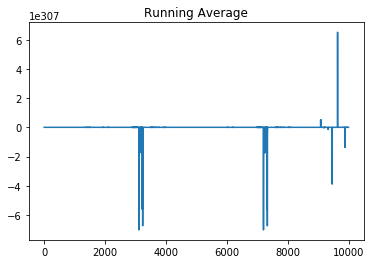

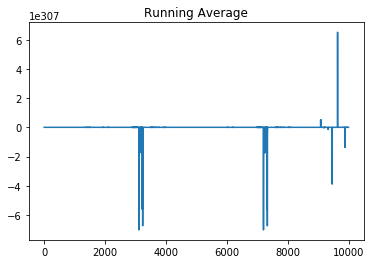

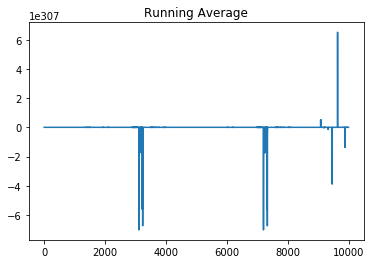

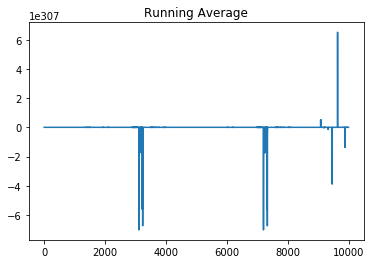

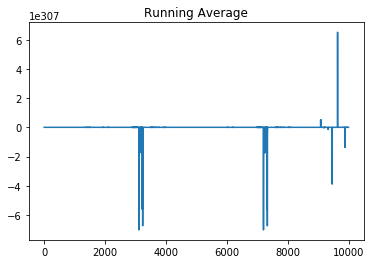

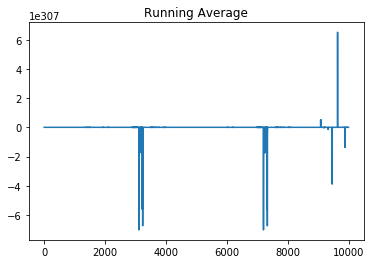

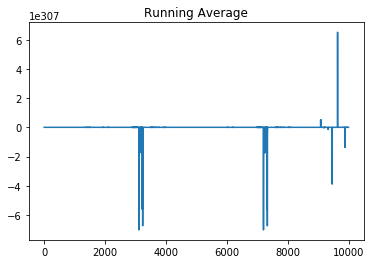

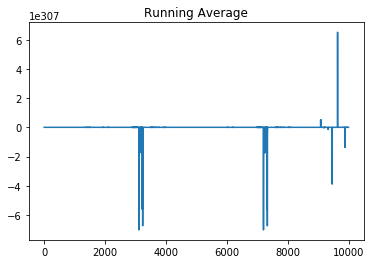

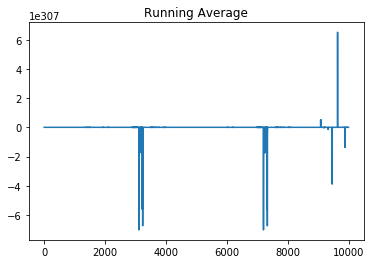

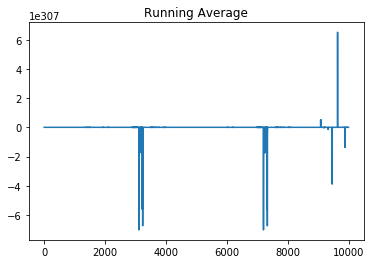

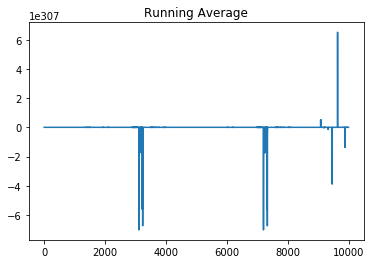

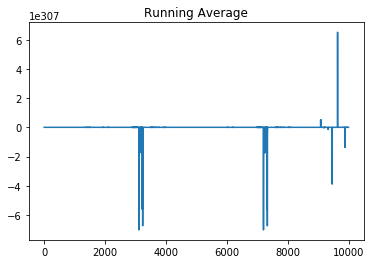

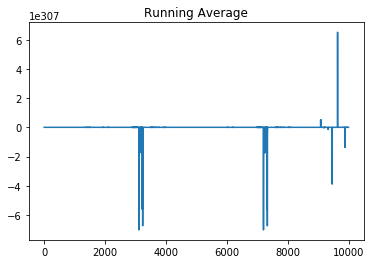

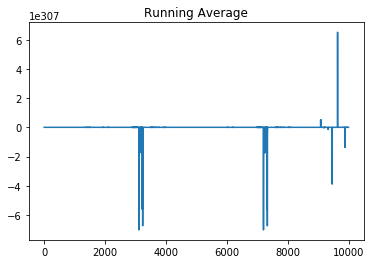

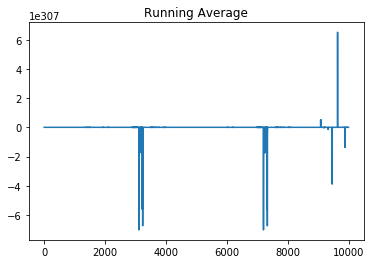

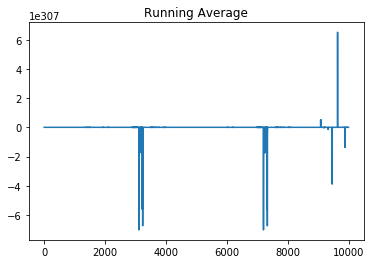

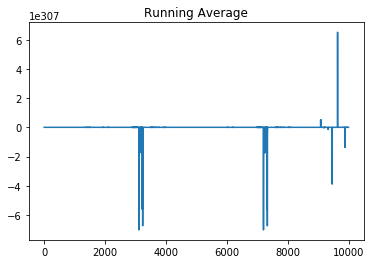

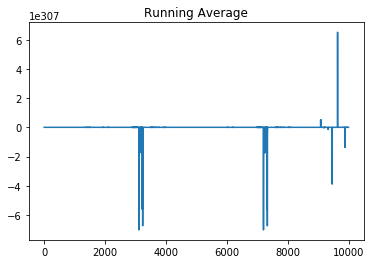

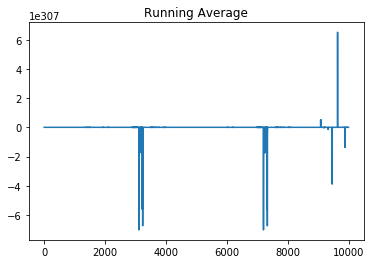

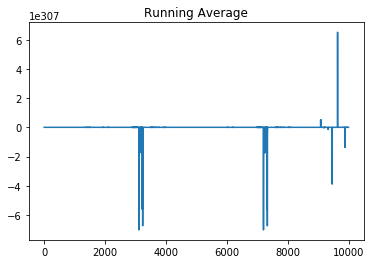

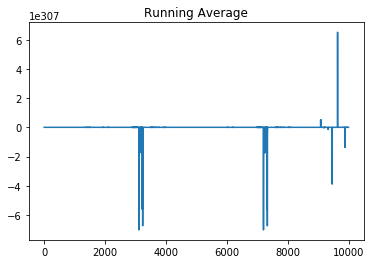

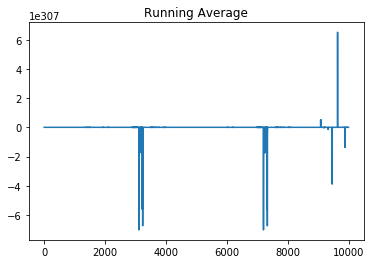

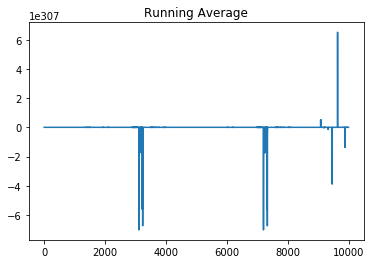

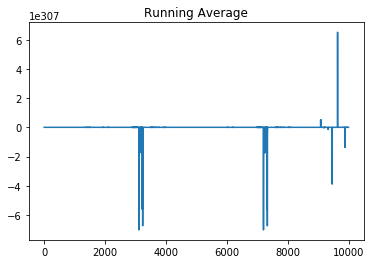

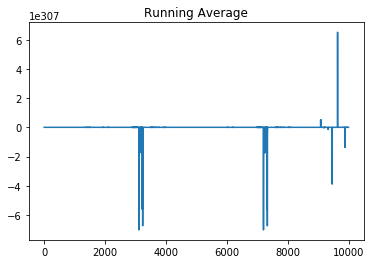

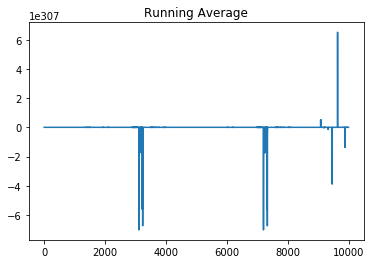

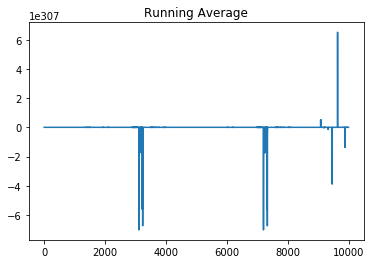

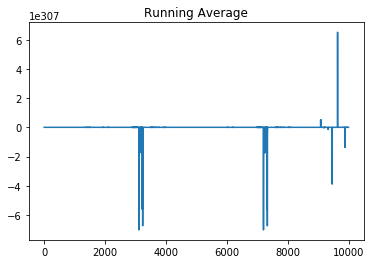

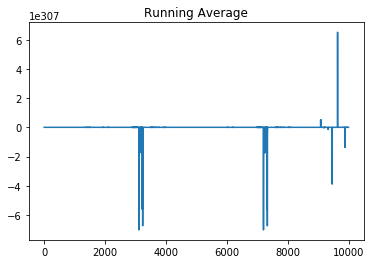

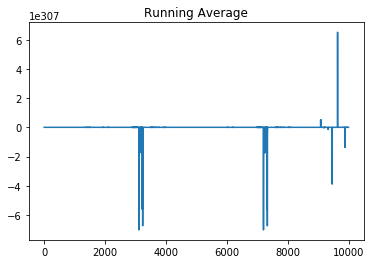

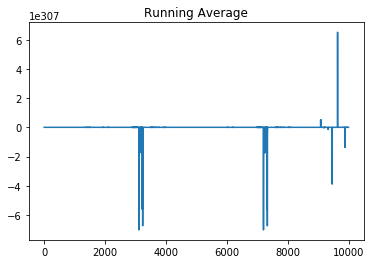

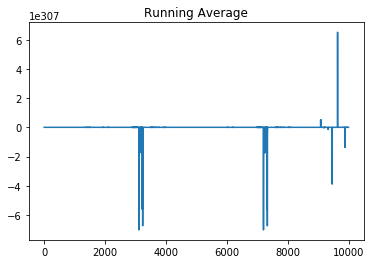

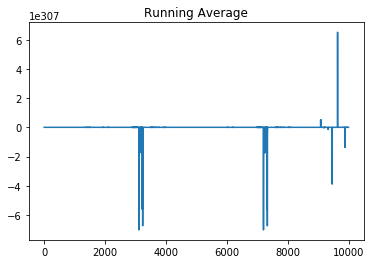

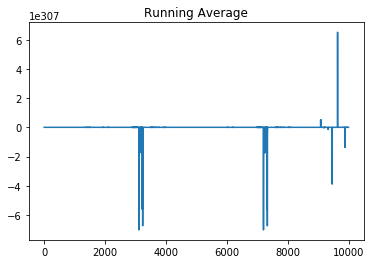

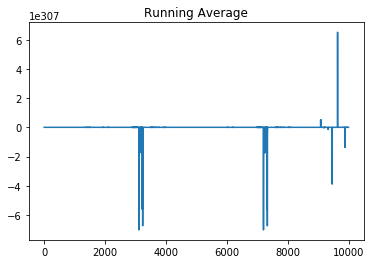

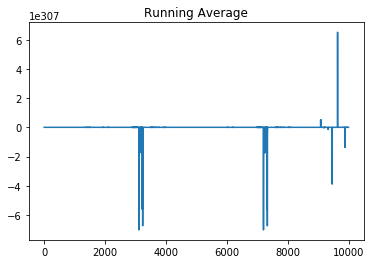

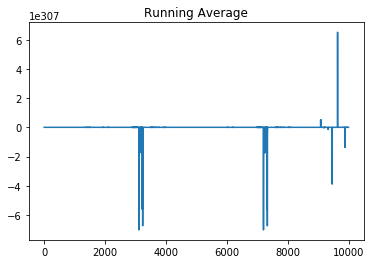

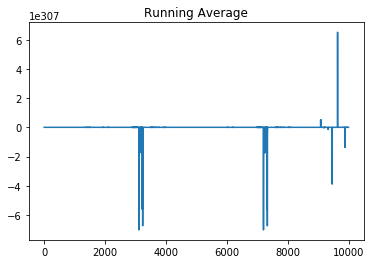

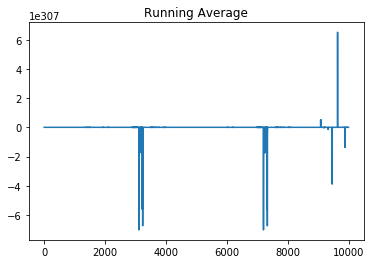

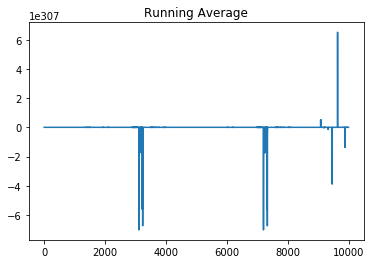

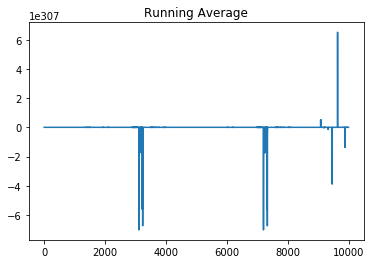

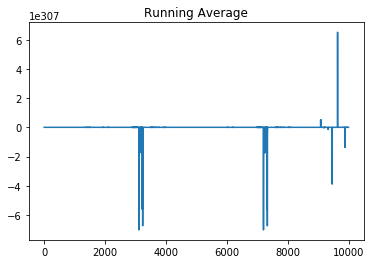

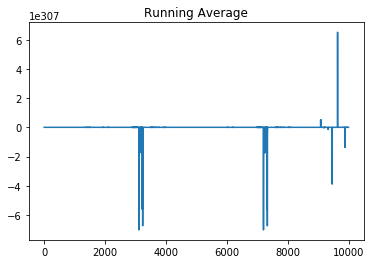

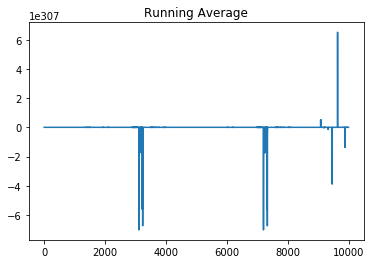

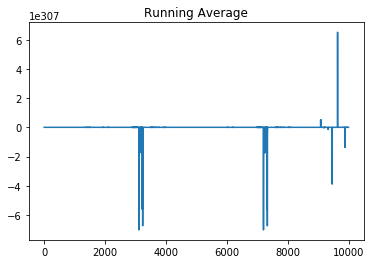

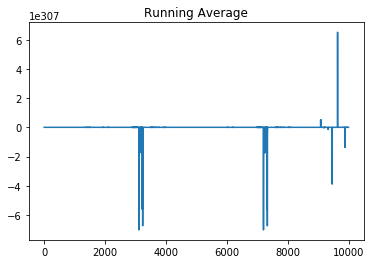

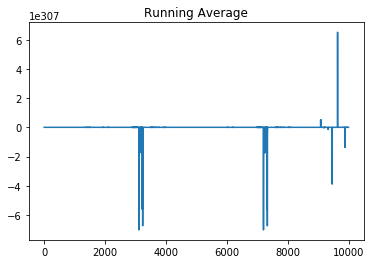

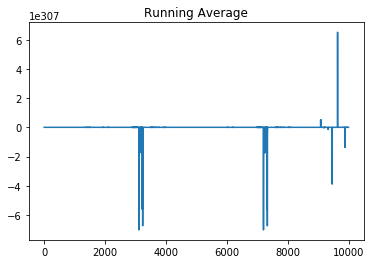

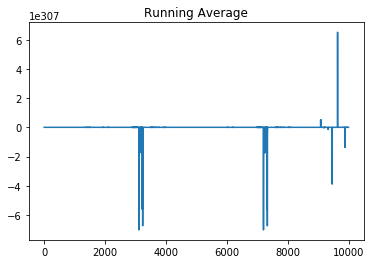

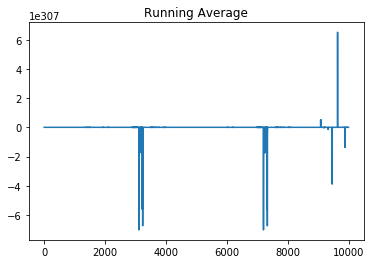

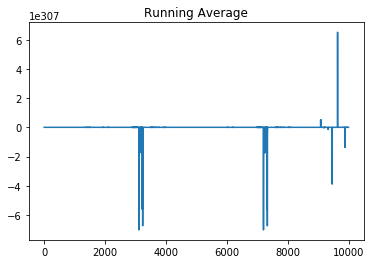

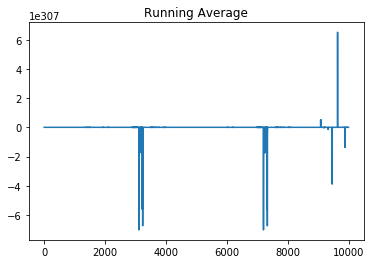

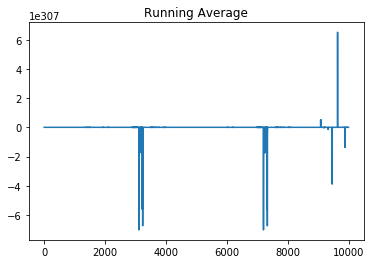

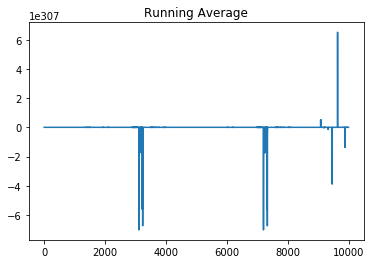

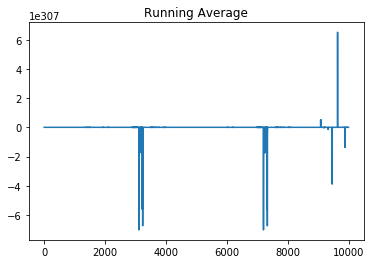

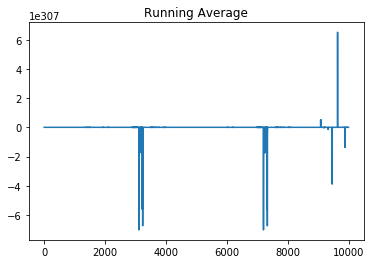

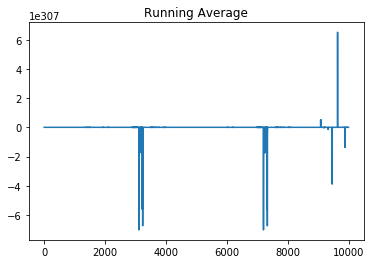

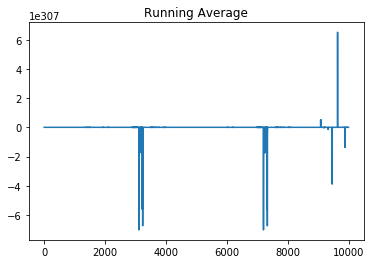

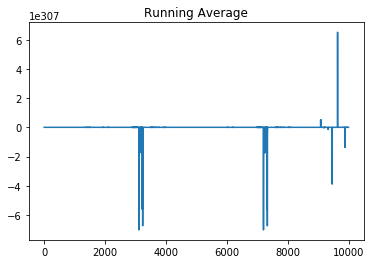

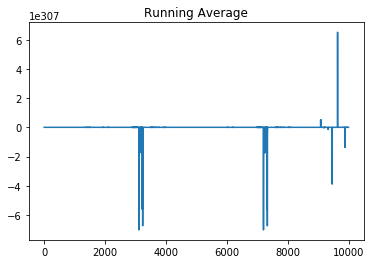

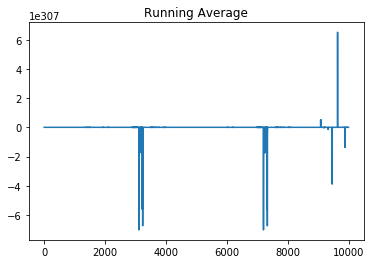

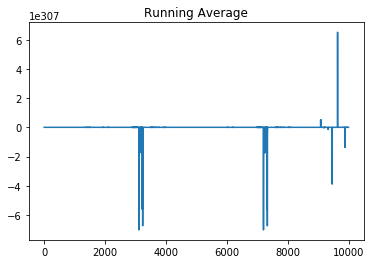

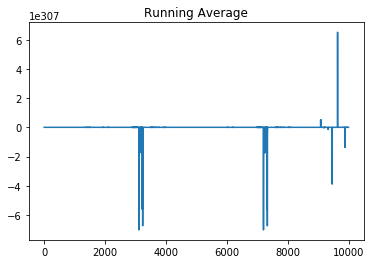

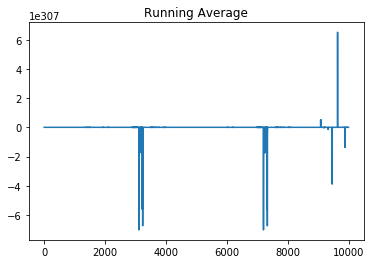

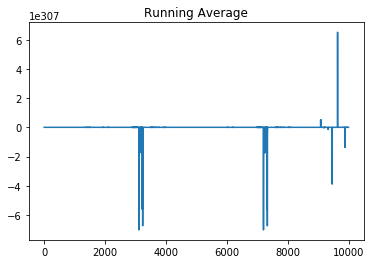

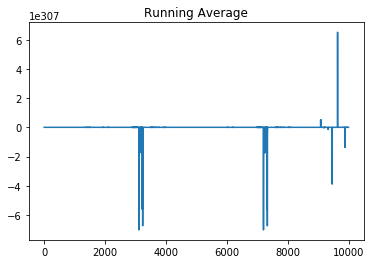

In [ ]:
if __name__ == '__main__':
    env = gym.make('CartPole-v0')
    ft = FeatureTransformer()
    model = Model(env, ft)
    gamma = 0.9
    if 'monitor' in sys.argv:
        filename = os.path.basename(__file__).split('.')[0]
        monitor_dir = './' + filename + '_' + str(datetime.now())
        env = wrappers.Monitor(env, monitor_dir)
    N = 10000
    totalrewards = np.empty(N)
    for n in range(N):
        eps = 1.0/np.sqrt(n+1)
        totalreward = play_one(model, eps, gamma)
        totalrewards[n] = totalreward
        if n%100 == 0:
            print("episode:", n, "total reward:", totalreward, "eps:", eps)
    print("avg reward for last 100 episodes:", totalrewards[-100:].mean())
    print("total steps:", totalrewards.sum())

    plt.plot(totalrewards)
    plt.title("Rewards")
    plt.show()

    plot_running_avg(totalrewards)